
So far, several regressors had already been tested. 
Most notably, the naive seasonal forecasters, the intermittent demand forecasting strategies as well as the TBATS.

Aiming to find a regressor that could lead to an improved model when combined with a classifier, more regressors were examined in the following. 

First, the EBM regressor was investigated (data not shown). Unfortuantely, the EBM regressor performed very poorly. The reason for that appeared to be that the regressor was predicting too close to the target. 
While good generalization ability of the model is definitely desired, the problem with this is that the EBM is not able to yield prediction intervals (yet?). Thereby, predictions are underpredicting most of the time, leading to horrible performance in the business metrics.

Therefore, the EBM regressor was dropped and only regressors able of probabilistic forecasting were considered in the following.

Next, the use of deep learning approaches came to mind using packages such as GluonTS https://ts.gluon.ai/stable/ and pytorch forecasting https://pytorch-forecasting.readthedocs.io/en/stable/.
Unfortunately, getting those packages to run on a Windows machine proved to be rather difficult, costing me a good number of hours. Furthermore, properly understanding the APIs constitutes a major barrier to entry as the documentation still leaves a lot to be desired, where the parameters of the functions are not introduced thoroughly enough for my taste.
After spending a day or two, I THINK I managed to train pytorch forecasting's NBeats for at least one expanding window, though I am really not sure about it. 
However, as the predictions (data not shown) did not appear to be substantially better than those of TBATS after visual inspection, NBeats was dropped from the list of potential candidates prematurely.

Though there were still some interesting models left in the two packages, I chose not to implement them for the time being as this would constitute a hefty time investment since the API was still kind of cryptic to me and GluonTS was still not running on my system after a few hours of bugfixing.

In the context of recent publications this may not be such a big issue however, as statistical procedures appear to beat deep learning approaches most often in performance (https://pubmed.ncbi.nlm.nih.gov/29584784/), at least when sample sizes are rather low as it is the case for the current project ( https://deepai.org/publication/machine-learning-vs-statistical-methods-for-time-series-forecasting-size-matters). Therefore, the focus was chosen to stay on statistical methods for regression.

Next, the use of SARIMAX models was investigated. Historically, those models were always handcrafted which requires profound knowledge in statistical timeseries analysis. Nowadays, luckily, there are algorithms available for parameter selection. Unfortunately, however, the automatic procedure may not reveal the truly best performing model as the default algorithm has some limitations in that not all potential parameter combinations are considered (https://otexts.com/fpp2/arima-r.html).

Out of interest, the manual procedure was considered first, where it is attempted to handcraft a model. 

After researching the methods a while, ACF and PACF plots were created for various differencing steps using sktime. Unfortunately, ACF and PACF plots from the differenced data in the current project look nothing like the example ACF and PACF plots in the learning material I was using (especially when using second order differencing). Confused with the interpretation of such plots, I decided to swallow my pride, stop the handcrafting journey here, and resort to the autoSARIMX for the time being.

That said, interestingly, the differenced data plots reminded me of timeseries that you would use GARCH models for, suggesting that the timeseries could potentially be predicted by training a GARCH model on a differenced version of the current dataset.
Unfortunately, there is no python package available at the moment that allows you to implement GARCH models out of the box.
Thus, it was considered to use R's rugarch package in jupyter notebooks by calling it via rpy2. Unluckily, rpy2 support on Windows machines appears to be rather limited, leading to problems when trying to implement it, even when using my WSL2 setup. 
Further, my R skills are even less developed than my python skills.
Thus, the GARCH approach was also dropped for the time being.

In the following, data and functions are loaded after which the autoSARIMAX will be implemented as a regressor.

If short on time: 
The Tldr is that none of the SARIMAX models here is able to compete with TBATS in terms of business metric performance.
The next notebook will be errors_and_interpret notebook.

In [1]:
import pandas as pd
import holidays
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import make_forecasting_scorer
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTEN
from sktime.forecasting.tbats import TBATS
from interpret.glassbox import ExplainableBoostingClassifier

In [2]:


pd.set_option('display.max_columns', None)

%matplotlib inline

data = pd.read_csv("sickness_table.csv")
data.drop(data.columns[0], axis = 1, inplace = True)

data["date"] = pd.to_datetime(data["date"])
#data.set_index("date", inplace = True)

data["sby_required"] = data["sby_need"] > 0
data["day_of_month"] = data["date"].dt.day
data["weekday"] = data["date"].dt.day_of_week
data["weekday_name"] = data["date"].dt.day_name()
data["month"] = data["date"].dt.month
data["month_name"] = data["date"].dt.month_name()
data["year"] = data["date"].dt.year
data["is_weekend"] = (data["weekday_name"] == "Saturday") | (data["weekday_name"] == "Sunday")

# create column indicating public holidays
holidays_berlin = holidays.DE(subdiv = "BE", years = [2016, 2017, 2018, 2019])

#initiate column
data["is_holiday"] = False

#set true if date is holiday
for index in range(len(data["date"])):
    if data.loc[index, "date"] in holidays_berlin:
        data.loc[index, "is_holiday"] = True

#crate column indicating school holidays
holidays_school = []
holidays_school.append(pd.date_range("2016-04-01", periods = 1)) #Osterferien
holidays_school.append(pd.date_range("2016-05-06", periods = 1)) #Pfingstferien
holidays_school.append(pd.date_range("2016-05-17", periods = 2)) #Pfingstferien
holidays_school.append(pd.date_range("2016-07-21", periods = 2)) #Sommerferien
holidays_school.append(pd.date_range("2016-07-25", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-08-01", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-08-01", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-08-08", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-08-15", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-08-22", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-08-29", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2016-10-17", periods = 5)) #Herbstferien
holidays_school.append(pd.date_range("2016-10-24", periods = 5)) #Herbstferien
holidays_school.append(pd.date_range("2016-12-23", periods = 1)) #Weihnachtsferien
holidays_school.append(pd.date_range("2016-12-27", periods = 4)) #Weihnachtsferien
holidays_school.append(pd.date_range("2017-01-02", periods = 2)) #Weihnachtsferien
holidays_school.append(pd.date_range("2017-01-30", periods = 5)) #Winterferien
holidays_school.append(pd.date_range("2017-04-10", periods = 4)) #Osterferien
holidays_school.append(pd.date_range("2017-04-18", periods = 1)) #Osterferien
holidays_school.append(pd.date_range("2017-05-24", periods = 1)) #Pfingstferien
holidays_school.append(pd.date_range("2017-05-26", periods = 1)) #Pfingstferien
holidays_school.append(pd.date_range("2017-06-06", periods = 4)) #Pfingstferien
holidays_school.append(pd.date_range("2017-07-20", periods = 1)) #Sommerferien
holidays_school.append(pd.date_range("2017-07-24", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-07-31", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-08-01", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-08-07", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-08-14", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-08-21", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-08-28", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2017-10-02", periods = 1)) #Herbstferien
holidays_school.append(pd.date_range("2017-10-23", periods = 5)) #Herbstferien
holidays_school.append(pd.date_range("2017-10-30", periods = 1)) #Herbstferien
holidays_school.append(pd.date_range("2017-11-01", periods = 3)) #Herbstferien
holidays_school.append(pd.date_range("2017-12-21", periods = 2)) #Weihnachtsferien
holidays_school.append(pd.date_range("2017-12-27", periods = 3)) #Weihnachtsferien
holidays_school.append(pd.date_range("2018-01-02", periods = 1)) #Weihnachtsferien
holidays_school.append(pd.date_range("2018-02-05", periods = 5)) #Winterferien
holidays_school.append(pd.date_range("2018-03-26", periods = 4)) #Osterferien
holidays_school.append(pd.date_range("2018-04-06", periods = 4)) #Osterferien
holidays_school.append(pd.date_range("2018-04-30", periods = 1)) #Pfingstferien
holidays_school.append(pd.date_range("2018-05-11", periods = 1)) #Pfingstferien
holidays_school.append(pd.date_range("2018-05-22", periods = 1)) #Pfingstferien
holidays_school.append(pd.date_range("2018-07-05", periods = 2)) #Sommerferien
holidays_school.append(pd.date_range("2018-07-09", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2018-07-16", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2018-07-23", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2018-07-30", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2018-08-06", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2018-08-13", periods = 5)) #Sommerferien
holidays_school.append(pd.date_range("2018-10-22", periods = 5)) #Herbstferien
holidays_school.append(pd.date_range("2018-10-29", periods = 5)) #Herbstferien
holidays_school.append(pd.date_range("2018-12-24", periods = 1)) #Weihnachtsferien
holidays_school.append(pd.date_range("2018-12-31", periods = 5)) #Weihnachtsferien
holidays_school.append(pd.date_range("2019-02-04", periods = 5)) #Winterferien
holidays_school.append(pd.date_range("2019-04-15", periods = 4)) #Osterferien
holidays_school.append(pd.date_range("2019-04-23", periods = 4)) #Osterferien
holidays_school.append(pd.date_range("2019-05-31", periods = 1)) #Osterferien

#flatten list
holidays_school = list(itertools.chain(*holidays_school))

data["is_school_holiday"] = False

#set true if date is holiday
for index in range(len(data["date"])):
    if data.loc[index, "date"] in holidays_school:
        data.loc[index, "is_school_holiday"] = True

data["kids_out_of_school"] = data["is_school_holiday"] | data["is_holiday"]

# season feature
data["season"] = "winter"
data.loc[(data["month"] >= 3) & (data["month"] <= 5), "season"] = "spring"
data.loc[(data["month"] >= 6) & (data["month"] <= 8), "season"] = "summer"
data.loc[(data["month"] >= 9) & (data["month"] <= 11), "season"] = "fall"


# week of the month count feature
data["week_num"] = 1
data.loc[(data["day_of_month"] > 7) & (data["day_of_month"] < 15), "week_num"] = 2
data.loc[(data["day_of_month"] > 14) & (data["day_of_month"] < 22), "week_num"] = 3
data.loc[(data["day_of_month"] > 21) & (data["day_of_month"] < 29), "week_num"] = 4
data.loc[data["day_of_month"] > 28, "week_num"] = 5

#print(data["day_of_month"].dtype)

#add the "unique_id" column for statsforecast regressors
data["unique_id"] = "sby_need"

# rename for statsforecast input df format
data.rename({"date": "ds", "sby_need": "y"}, axis = 1, inplace=True)



data

ds  n_sick   calls  n_duty  n_sby      y  dafted  sby_required  \
0    2016-04-01      73  8154.0    1700     90    4.0     0.0          True   
1    2016-04-02      64  8526.0    1700     90   70.0     0.0          True   
2    2016-04-03      68  8088.0    1700     90    0.0     0.0         False   
3    2016-04-04      71  7044.0    1700     90    0.0     0.0         False   
4    2016-04-05      63  7236.0    1700     90    0.0     0.0         False   
...         ...     ...     ...     ...    ...    ...     ...           ...   
1147 2019-05-23      86  8544.0    1900     90    0.0     0.0         False   
1148 2019-05-24      81  8814.0    1900     90    0.0     0.0         False   
1149 2019-05-25      76  9846.0    1900     90  146.0    56.0          True   
1150 2019-05-26      83  9882.0    1900     90  160.0    70.0          True   
1151 2019-05-27      77  8790.0    1900     90    0.0     0.0         False   

      day_of_month  weekday weekday_name  month month_name  year  is_weekend  \
0                1        4       Friday      4      April  2016       False   
1                2        5     Saturday      4      April  2016        True   
2                3        6       Sunday      4      April  2016        True   
3                4        0       Monday      4      April  2016       False   
4                5        1      Tuesday      4      April  2016       False   
...            ...      ...          ...    ...        ...   ...         ...   
1147            23        3     Thursday      5        May  2019       False   
1148            24        4       Friday      5        May  2019       False   
1149            25        5     Saturday      5        May  2019        True   
1150            26        6       Sunday      5        May  2019        True   
1151            27        0       Monday      5        May  2019       False   

      is_holiday  is_school_holiday  kids_out_of_school  season  week_num  \
0          False               True                True  spring         1   
1          False              False               False  spring         1   
2          False              False               False  spring         1   
3          False              False               False  spring         1   
4          False              False               False  spring         1   
...          ...                ...                 ...     ...       ...   
1147       False              False               False  spring         4   
1148       False              False               False  spring         4   
1149       False              False               False  spring         4   
1150       False              False               False  spring         4   
1151       False              False               False  spring         4   

     unique_id  
0     sby_need  
1     sby_need  
2     sby_need  
3     sby_need  
4     sby_need  
...        ...  
1147  sby_need  
1148  sby_need  
1149  sby_need  
1150  sby_need  
1151  sby_need  

[1152 rows x 21 columns]

In [3]:
def calc_confusion(y_true, y_pred):
    
    df = pd.DataFrame({"true": y_true, "pred": y_pred})
    
    TP = len(df[(df["true"] == 1) & (df["pred"] == 1)])
    TN = len(df[(df["true"] == 0) & (df["pred"] == 0)])
    FP = len(df[(df["true"] == 0) & (df["pred"] == 1)])
    FN = len(df[(df["true"] == 1) & (df["pred"] == 0)])
    
    if TP + FN == 0:
        TRP = 0
    else:
        TRP = TP / (TP + FN)
        
    if TN + FP == 0:
        TNR = 0
    else:
        TNR = TN / (TN + FP)
    
    if TP + FP == 0:
        prec = 0
    else:
        prec = TP / (TP + FP)
    
    return TP, FP, TN, FN, TRP, TNR, prec
    
#calc_confusion(np.array([0, 0, 1, 1]), np.array([0,1,0,1]))

In [4]:
def interpretable_scores(y_true, y_pred, debug_printing = False):
    """ 
        
    Score function based on the business goals.
    
    inputs have to be np arrays.
    
    calculates two losses based on the business goals.
    
    first goal: 
    loss is the percent difference in activated sby drivers
    
    values over 100 % drivers activated need to be capped to 100% or penalized.
    otherwise, underpredicting would be beneficial.
    
    first, I calculate a loss_1 where I decided to cap the value for the percentage of activated drivers to 100.
    thereby, the magnitude of underpredicting will not be penalized. 
    instead, the loss is the literal efficiency of sby driver activation.
    importantly, this will give you a positive loss in the following example:
    true: 100, benchmark: 90, pred: 110.
    both the benchmark and the pred are off by 10, 
    but you've lost efficiency by overpredicting!
    
   
    second goal:
    count delta of number of occasions on which additional sby drivers 
    have to be recruited.
    
    furthermore, the magnitude of underpredictions is calculated to judge whether
    the model under investigation is getting closer to the true value when underpredicting 
    than the baseline. 

    """
    import math
    
        
    #################
    # 1. goal
    #################
    
    # compare the mean percentage of sby drivers being activated.
    benchmark_sby_activated = (1 - (90 - y_true) / 90) * 100
    pred_sby_activated = np.where(y_pred!=0,  (1 - (y_pred - y_true) / y_pred) * 100, 100)
    
    if debug_printing == True:
        print("1st goal: efficiency of sby driver activation")
        print(f"benchmark_sby_activated: {benchmark_sby_activated}")
        print(f"pred_sby_activated: {pred_sby_activated}")
        
    #cap the % activation to 100.
    benchmark_sby_activated[benchmark_sby_activated > 100] = 100
    pred_sby_activated[pred_sby_activated > 100] = 100
    
    if debug_printing == True:
        print("after capping:")
        print(f"benchmark_sby_activated: {benchmark_sby_activated}")
        print(f"pred_sby_activated: {pred_sby_activated}")
    
    #unpenalized efficiency score
    avg_benchmark_sby_activated = np.mean(benchmark_sby_activated)
    avg_pred_sby_activated = np.mean(pred_sby_activated)  
    
    # if the difference is < 0 we are meeting business goals
    loss_1 = avg_benchmark_sby_activated - avg_pred_sby_activated

    if debug_printing == True:
        print("averages:")
        print(f"benchmark_sby_activated: {avg_benchmark_sby_activated}")
        print(f"pred_sby_activated: {avg_pred_sby_activated}")
        print(f"On average, the prediction is {loss_1} % less efficient.")

    #################
    # 2. goal
    #################
    
    num_times_benchmark_undershoots = np.count_nonzero(y_true > 90)
    num_times_pred_undershoots = np.count_nonzero(y_true > y_pred)

    # if the difference is y < we are meeting business goals
    loss_2 = num_times_pred_undershoots - num_times_benchmark_undershoots
        
    if debug_printing == True:
        print("\n2nd goal: number of times undershooting")
        print(f"num_times_benchmark_undershoots: {num_times_benchmark_undershoots}")
        print(f"num_times_pred_undershoots: {num_times_pred_undershoots}") 
        print(f"Your predictions undershoot {loss_2} times more often.")
        
    #2. goal: the average magnitude of undershooting, 
    # i.e., the average gap between the preds and the trues
    benchmark_gaps = y_true - 90
    y_pred_gaps = y_true - y_pred
    
    if debug_printing == True:
        print("\n2nd goal: avg number additional drivers required when undershooting")
        print(f"benchmark_gaps: {benchmark_gaps}")
        print(f"y_pred_gaps: {y_pred_gaps}") 
    
    #filter the negative values
    benchmark_gaps = [x for x in benchmark_gaps if x > 0]
    y_pred_gaps = [x for x in y_pred_gaps if x > 0]
    
    if debug_printing == True:
        print("after filtering out values <= 0")
        print(f"benchmark_gaps: {benchmark_gaps}")
        print(f"y_pred_gaps: {y_pred_gaps}") 
    
    #average gap sizes
    avg_benchmark_gaps = np.mean(benchmark_gaps)
    avg_pred_gaps = np.mean(y_pred_gaps) 
    
    # the avg can be nan if there no values,
    # so they're set to 0 here
    if math.isnan(avg_benchmark_gaps):
        avg_benchmark_gaps = 0
    if math.isnan(avg_pred_gaps):
        avg_pred_gaps = 0
    
    #delta: lower is better
    loss_3 = avg_pred_gaps - avg_benchmark_gaps 
            
    if debug_printing == True:
        print(f"avg_benchmark_gaps: {avg_benchmark_gaps}")
        print(f"avg_pred_gaps: {avg_pred_gaps}")
        print(f"On average, {loss_3} additional drivers have to be recruited compared to benchmark when underpredicting.\n")
        
    return loss_1, loss_2, loss_3



In [5]:
year_split = {"first": {"last_train_day": "2018-05-15",
                   "first_test_day": "2018-06-01",
                   "last_test_day": "2018-06-30",
                   "month": "June"},
              
                "second": {"last_train_day": "2018-06-15",
                   "first_test_day": "2018-07-01",
                   "last_test_day": "2018-07-31",
                   "month": "July"},
              
                "third": {"last_train_day": "2018-07-15",
                   "first_test_day": "2018-08-01",
                   "last_test_day": "2018-08-31",
                   "month": "August"},
              
                "fourth": {"last_train_day": "2018-08-15",
                   "first_test_day": "2018-09-01",
                   "last_test_day": "2018-09-30",
                   "month": "September"},
              
                "fifth": {"last_train_day": "2018-09-15",
                   "first_test_day": "2018-10-01",
                   "last_test_day": "2018-10-31",
                   "month": "October"},
              
                "sixth": {"last_train_day": "2018-10-15",
                   "first_test_day": "2018-11-01",
                   "last_test_day": "2018-11-30",
                   "month": "November"},
              
                "seventh": {"last_train_day": "2018-11-15",
                   "first_test_day": "2018-12-01",
                   "last_test_day": "2018-12-31",
                   "month": "December"},
              
                "eighth": {"last_train_day": "2018-12-15",
                   "first_test_day": "2019-01-01",
                   "last_test_day": "2019-01-31",
                   "month": "January"},              
    
                "nineth": {"last_train_day": "2019-01-15",
                   "first_test_day": "2019-02-01",
                   "last_test_day": "2019-02-28",
                   "month": "February"},
          
                 "tenth": {"last_train_day": "2019-02-15",
                   "first_test_day": "2019-03-01",
                   "last_test_day": "2019-03-31",
                   "month": "March"},
          
                 "eleventh": {"last_train_day": "2019-03-15",
                   "first_test_day": "2019-04-01",
                   "last_test_day": "2019-04-30",
                  "month": "April"},
          
                 "twelvth": {"last_train_day": "2019-04-15",
                   "first_test_day": "2019-05-01",
                   "last_test_day": "2019-05-27",
                   "month": "May"}
         }


In [6]:
def cv_ebm_class_one_year(statsforecast_df, splits_dict, custom_scorer, plotting = True, 
                          outer_bags = 8, inner_bags = 0, max_bins = 256, early_stopping_rounds = 50,
                          early_stopping_tolerance = 0.0001, max_leaves = 3, interactions = 10,
                          max_interaction_bins = 32,
                          oversampler = "None", decision_thr = 0.2,
                         print_mean = True, print_per_month = False):
    """
    function to perform cv for a given model
    
    
    """

    
    #init lists to append probas and classifiers for single months 
    train_proba_list = []
    train_pred_list = [] # binary prediction based on decision thr 
    train_TPs = []
    train_FPs = []
    train_TNs = []
    train_FNs = []
    train_TPRs = []
    train_TNRs = []
    train_precisions = []
    
    test_proba_list = []
    test_pred_list = [] # binary prediction based on decision thr 
    test_TPs = []
    test_FPs = []
    test_TNs = []
    test_FNs = []
    test_TPRs = []
    test_TNRs = []
    test_precisions = []
    
    classifiers = []
    
    #plotting
    if plotting == True:
        fig, axes = plt.subplots(6, 2, figsize = (60,60))
        # a counter to get the correct ax object
        i = 0
    
    for split in splits_dict.keys(): 
        
        #extract data from the splits_dict for enhanced readability inside the function
        last_train_day = splits_dict[split]["last_train_day"]
        first_test_day = splits_dict[split]["first_test_day"]
        last_test_day = splits_dict[split]["last_test_day"]
        month = splits_dict[split]["month"]

        #classifier dfs
        X_train_clf_df = statsforecast_df[statsforecast_df.ds <= last_train_day].drop(columns = ["ds", "sby_required", 
                                                                                                 "y"])
        Y_train_clf_df = statsforecast_df[statsforecast_df.ds <= last_train_day]["sby_required"]
        X_test_clf_df = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)].drop(columns = ["ds", "sby_required", 
                                                                                            "y"])
        Y_test_clf_df = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)]["sby_required"]      

        if oversampler == "smote":
            X_train_clf_df, Y_train_clf_df = SMOTE(random_state = 0).fit_resample(X_train_clf_df.astype("int"), Y_train_clf_df.astype("int"))
        elif oversampler == "smoten":
            X_train_clf_df, Y_train_clf_df = SMOTEN(random_state = 0).fit_resample(X_train_clf_df.astype("int"), Y_train_clf_df.astype("int"))
            #print(X_train_clf_df)
        elif oversampler == "adasyn":
            X_train_clf_df, Y_train_clf_df = ADASYN(random_state = 0).fit_resample(X_train_clf_df.astype("int"), Y_train_clf_df.astype("int"))
        elif oversampler == "random":
            X_train_clf_df, Y_train_clf_df = RandomOverSampler(random_state=0).fit_resample(X_train_clf_df.astype("int"), Y_train_clf_df.astype("int"))

        clf = ExplainableBoostingClassifier(random_state=1, 
                                            outer_bags = outer_bags, 
                                            inner_bags = inner_bags, 
                                            max_bins = max_bins, 
                                            early_stopping_tolerance = early_stopping_tolerance, 
                                            max_leaves = max_leaves, 
                                            interactions = interactions,
                                           max_interaction_bins = max_interaction_bins)
        
        clf.fit(X_train_clf_df, Y_train_clf_df)
        classifiers.append(clf)
                
        # get insample predictions   
        train_probas = clf.predict_proba(X=X_train_clf_df)[:,1] #select the probas for class 1
        train_proba_list.append(train_probas)
        train_pred = train_probas > decision_thr
        train_pred_list.append(train_pred)
        
        train_TP, train_FP, train_TN, train_FN, train_TPR, train_TNR, train_prec = calc_confusion(Y_train_clf_df.values, 
                                                                                                 train_pred)
        
        train_TPs.append(train_TP)
        train_FPs.append(train_FP)
        train_TNs.append(train_TN)
        train_FNs.append(train_FN)
        train_TPRs.append(train_TPR)
        train_TNRs.append(train_TNR)
        train_precisions.append(train_prec)
        
        # get test predictions
        test_probas = clf.predict_proba(X=X_test_clf_df)[:,1] #select the probas for class 1
        test_proba_list.append(test_probas)
        test_pred = test_probas > decision_thr
        test_pred_list.append(test_pred)
        
        test_TP, test_FP, test_TN, test_FN, test_TPR, test_TNR, test_prec = calc_confusion(Y_test_clf_df.values, 
                                                                                                 test_pred)
        
        test_TPs.append(test_TP)
        test_FPs.append(test_FP)
        test_TNs.append(test_TN)
        test_FNs.append(test_FN)
        test_TPRs.append(test_TPR)
        test_TNRs.append(test_TNR)
        test_precisions.append(test_prec)
        
        if print_per_month:
            print(f"\n\nmonth {month}\n\n")
            print(f"train_TPR: {train_TPR}")
            print(f"train_TNR: {train_TNR}")
            print(f"train_prec: {train_prec}")
            print(f"\ntest_TPR: {test_TPR}")
            print(f"test_TNR: {test_TNR}")
            print(f"test_prec: {test_prec}")
        
        if plotting == True:
        # plotting
            ax = axes.flat[i]
    
            ax.plot(Y_test_clf_df.index, Y_test_clf_df, label = "sby_req")
            ax.plot(Y_test_clf_df.index, test_probas, label = "probas")
            ax.set_title(month, size = 20)    
            ax.set_ylabel("sby are required", size = 20, labelpad = 20)
            ax.tick_params(axis = "x", rotation = 45)  
            ax.legend()
    
            # iterate the counter for the ax object
            i += 1

    if print_mean:
            print(f"\nmean train_TPR: {np.mean(train_TPRs)}")
            print(f"mean train_TNR: {np.mean(train_TNRs)}")
            print(f"mean train_prec: {np.mean(train_precisions)}")
            print(f"\nmean test_TPR: {np.mean(test_TPRs)}")
            print(f"mean test_TNR: {np.mean(test_TNRs)}")
            print(f"mean test_prec: {np.mean(test_precisions)}")
    
    #https://datagy.io/pandas-dataframe-from-list/
    zipped = list(zip(classifiers, 
                      test_proba_list))

    output_df = pd.DataFrame(zipped, columns = ["classifiers",
                                               "test_proba_list"])
    
    return output_df

In [16]:
def combine_clf_reg(statsforecast_df, clf_probas, reg_preds, splits_dict, custom_scorer, plotting = True,
                     print_per_month = True, print_mean = True, smoothing = None, decision_thr = 0.2, plot_historical = True):
    """
    function to perform cv for a given statsforecast model
    
    
    """

    #init lists to append scores for single months 
    # to calculate average scores for all folds
    efficiency_losses = []
    num_undershoots = []
    magnitude_undershoots = []
    y_trues_list = []
    y_preds_list = []
    y_uncorr_preds_list = []
    X_tests = []
    y_tests = []
    dates_list = []
    feature_names_list = []
    test_dfs = []

    
    #plotting
    if plotting == True:
        fig, axes = plt.subplots(6, 2, figsize = (60,60))
    
    # a counter to get the correct ax object and month
    i = 0
    
    for split in splits_dict.keys(): 
        
        #print(split)
        
        #extract data from the splits_dict for enhanced readability inside the function
        last_train_day = splits_dict[split]["last_train_day"]
        first_test_day = splits_dict[split]["first_test_day"]
        last_test_day = splits_dict[split]["last_test_day"]
        month = splits_dict[split]["month"]
        
        #extract train and test data
        X_test_df = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)].drop(columns = ["ds", "sby_required", 
                                                                                            "y",])
        Y_test_df = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)]["y"]
        
        dates = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)]["ds"]
        
        test_df = statsforecast_df[(statsforecast_df.ds >= first_test_day) & 
                                    (statsforecast_df.ds <= last_test_day)]

        
        X_tests.append(X_test_df.values)
        feature_names_list.append(X_test_df.columns.values)
        y_tests.append(Y_test_df.values)
        dates_list.append(dates.values)
        
        
        #calculate the length of the forecasting horizon
        horizon = len(statsforecast_df[(statsforecast_df.ds > last_train_day) &
                                      (statsforecast_df.ds <= last_test_day)])  
        
        #for the preds, you have to get rid of the timepoints 
        #from the last_train_day to the first_test_day, i.e.,
        #the leading period = approximately 15 days, depending on the month
        leading_days = len(statsforecast_df[(statsforecast_df.ds > last_train_day) &
                                      (statsforecast_df.ds < first_test_day)])
        
        
        probas = clf_probas[i]
        probas_bin = (probas >= decision_thr)
        y_hat = reg_preds[i]   
        y_hat_x_probas_bin = y_hat * probas_bin

        y_trues = Y_test_df.values.astype("float64") #manual typing required, otherwise bug in metrics calculations
       
        y_trues_list.append(y_trues)
        y_preds_list.append(y_hat_x_probas_bin)
        y_uncorr_preds_list.append(y_hat)
        
        # insert the probas and preds into test_df for output for later error explainability
        test_df["probas"] = probas
        test_df["y_preds"] = y_hat_x_probas_bin
        test_df["y_trues"] = y_trues # will be float64, thereby wrong types will not create issues later
        test_df["y_preds_uncorr"] = y_hat
        test_dfs.append(test_df)
        
        #calculate metrics
        efficiency_loss, num_undershoots_loss, magnitude_undershoots_loss = custom_scorer(y_trues, y_hat_x_probas_bin)
        efficiency_losses.append(efficiency_loss)
        num_undershoots.append(num_undershoots_loss)
        magnitude_undershoots.append(magnitude_undershoots_loss)
        
        if plotting == True:
        # plotting
            ax = axes.flat[i]    
            ax.plot(dates, y_trues, label = "y", linewidth = "5")
            ax.plot(dates, y_hat_x_probas_bin, label = "y_hat_x_probas_bin", linewidth = "5")
            ax.set_title(month, size = 30)    
            ax.set_ylabel("Number of standby drivers", size = 20, labelpad = 20)
            ax.tick_params(axis = "x", rotation = 45)  
            ax.axhline(y = 90, xmin = 0, xmax = 1, color = "grey",
                label = "current policy: 90 drivers", linewidth = "5")
                    
            if plot_historical == True:
                #get the training data 
                previous_years_months = statsforecast_df[(statsforecast_df.ds <= last_train_day)]
                
                #create features to slice the data
                previous_years_months["day_of_month"] = previous_years_months["ds"].dt.day
                previous_years_months["month_name"] = previous_years_months["ds"].dt.month_name()
                previous_years_months["year"] = previous_years_months["ds"].dt.year
                
                #get data from the same months of the previous years
                previous_years_months = previous_years_months[previous_years_months["month_name"] == month]
                
                for year in previous_years_months.year.unique():
                    y = previous_years_months[previous_years_months["year"] == year].y
                    
                    # in 2019 there are only 27 days in May available,
                    # so I exclude all days later than that in the plot
                    if 2019 in dates.dt.year.unique(): #check if the current year to be plotted is 2019
                        if month == "May":
                            y = y[:27]
                        
                    ax.plot(dates, y.values, linestyle = "--", label = f"y in {year}")
                                
                
            ax.legend()
            
            fig.subplots_adjust(hspace = 0.5)
    
        # iterate the counter for the ax object and month
        i += 1
        
        if print_per_month == True:                
            print(f"\nSplit for {month}")
            print(f"Forecasting for {str(horizon - leading_days)} days")
            print(f"Number of leading days: {leading_days}")
            print(f"Loss in efficiency = {efficiency_loss}")
            print(f"Number of additional underpredictions = {num_undershoots_loss}")
            print(f"Number of additional sby drivers required = {magnitude_undershoots_loss}")
    
    if print_mean == True:
        print("\n")
        print(f"Mean efficiency loss per month in percent = {np.mean(efficiency_losses)}")
        print(f"Mean number of additional underpredictions = {np.mean(num_undershoots)}")
        print(f"Mean number of additional sby drivers required = {np.mean(magnitude_undershoots)}")
    
    
    #https://datagy.io/pandas-dataframe-from-list/
    zipped = list(zip(efficiency_losses, 
                      num_undershoots,
                     magnitude_undershoots,
                     y_trues_list,
                     y_preds_list,
                     y_uncorr_preds_list,
                     X_tests,
                     y_tests,
                     dates_list,
                     feature_names_list,
                     test_dfs))

    output_df = pd.DataFrame(zipped, columns = ["efficiency_losses",
                                                "num_undershoots",
                                                "magnitude_undershoots",
                                                "y_trues_list",
                                                "y_preds_list",
                                                "y_uncorr_preds_list",
                                               "X_tests",
                                               "y_tests",
                                               "dates_list",
                                               "feature_names_list",
                                               "test_df"])

    
    return output_df

In [8]:
#the oversamplers appear to require numerical categories


num_encoded_df = data[["ds", "y", "sby_required", 
                       "weekday", "day_of_month", 
                       "month", "is_weekend", "kids_out_of_school",
                       "season", "week_num"]]


num_encoded_df.season.replace({"spring" : 1, "summer": 2, "fall": 3, "winter": 4}, inplace = True)

num_encoded_df

/tmp/ipykernel_13664/3642137161.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_encoded_df.season.replace({"spring" : 1, "summer": 2, "fall": 3, "winter": 4}, inplace = True)


ds      y  sby_required  weekday  day_of_month  month  \
0    2016-04-01    4.0          True        4             1      4   
1    2016-04-02   70.0          True        5             2      4   
2    2016-04-03    0.0         False        6             3      4   
3    2016-04-04    0.0         False        0             4      4   
4    2016-04-05    0.0         False        1             5      4   
...         ...    ...           ...      ...           ...    ...   
1147 2019-05-23    0.0         False        3            23      5   
1148 2019-05-24    0.0         False        4            24      5   
1149 2019-05-25  146.0          True        5            25      5   
1150 2019-05-26  160.0          True        6            26      5   
1151 2019-05-27    0.0         False        0            27      5   

      is_weekend  kids_out_of_school  season  week_num  
0          False                True       1         1  
1           True               False       1         1  
2           True               False       1         1  
3          False               False       1         1  
4          False               False       1         1  
...          ...                 ...     ...       ...  
1147       False               False       1         4  
1148       False               False       1         4  
1149        True               False       1         4  
1150        True               False       1         4  
1151       False               False       1         4  

[1152 rows x 10 columns]

In [9]:

clf_output = cv_ebm_class_one_year(num_encoded_df, year_split, interpretable_scores, decision_thr = 0.15,
                                                   plotting = False, print_per_month = False, print_mean = False,
                                                   oversampler = "smoten",
                                 outer_bags = 8, inner_bags = 8, max_bins = 256, early_stopping_rounds = 50,
                                          early_stopping_tolerance = 0.0001, max_leaves = 5, interactions = 16,)

In [10]:

clf_probas = clf_output["test_proba_list"].to_list()

In [11]:
def cv_sktime_models_one_year(model, statsforecast_df, splits_dict, custom_scorer, plotting = True,
                     print_per_month = True, print_mean = True, transformer = None, smoothing = None,
                             interval = None, SARIMAX_fourierterms = None):
    """
    function to perform cv for a given model
    
    
    """

    from sktime.transformations.series.boxcox import LogTransformer
    from sktime.transformations.series.boxcox import BoxCoxTransformer
    from sktime.forecasting.base import ForecastingHorizon
    from sktime.transformations.series.fourier import FourierFeatures
    from sklearn.metrics import mean_absolute_error

    
    #init lists to append scores for single months 
    # to calculate average scores for all folds
    efficiency_losses = []
    num_undershoots = []
    magnitude_undershoots = []
    y_pred_list = []
    regressors = []
    maes = []
    
    #plotting
    if plotting == True:
        fig, axes = plt.subplots(6, 2, figsize = (60,60))
        # a counter to get the correct ax object
        i = 0
    
    df = statsforecast_df.copy()
        
    # calculate fourier terms for SARIMAX.
    # has to be done first; does not depend on the values of y but their indices,
    # so you can do it once before splitting.
    #https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.fourier.FourierFeatures.html
    if SARIMAX_fourierterms != None:
           
        transformer = FourierFeatures(sp_list = [365.25, 30.4375, 7], 
                                          fourier_terms_list = SARIMAX_fourierterms)

        df = transformer.fit_transform(df.y)
        df["ds"] = statsforecast_df.ds
        #print(df.columns)
        #print(df)
    
    for split in splits_dict.keys(): 
        
        #extract data from the splits_dict for enhanced readability inside the function
        last_train_day = splits_dict[split]["last_train_day"]
        first_test_day = splits_dict[split]["first_test_day"]
        last_test_day = splits_dict[split]["last_test_day"]
        month = splits_dict[split]["month"]
        leading_days = len(df[(df.ds > last_train_day) &
                                      (df.ds < first_test_day)])
        
        #calculate the length of the forecasting horizon
        horizon = len(df[(df.ds > last_train_day) &
                                      (df.ds <= last_test_day)])  
        
        #extract train and test data
        Y_train_df = df[df.ds <= last_train_day]
        Y_test_df = df[(df.ds >= first_test_day) & 
                                    (df.ds <= last_test_day)]
        
        if SARIMAX_fourierterms != None:
            #X_test has to include data from the leading days to be properly queried later
            X_test_df = df[(df.ds > last_train_day) &
                                      (df.ds <= last_test_day)].drop(columns = ["y", "ds"], axis = 1)
        
        #print(horizon - leading_days)
        #print(len(X_test_df))
        #print(np.arange(leading_days, horizon))
        #print(len(np.arange(leading_days, horizon)))
        
        #smooth the data
        if smoothing == "MA_weekly":
            Y_train_df.y = Y_train_df.y.rolling(window = 7, center = True, closed = "both", min_periods = 1).mean()
        elif smoothing == "MA_monthly":
            Y_train_df.y = Y_train_df.y.rolling(window = 31, center = True, closed = "both", min_periods = 1).mean()
        if smoothing == "MA_oneday":
            Y_train_df.y = Y_train_df.y.rolling(window = 3, center = True, closed = "both", min_periods = 1).mean()
        elif smoothing == "EWM_monthly":
            Y_train_df.y = Y_train_df.y.ewm(span = 30, min_periods = 1).mean()
        elif smoothing == "EWM_weekly":
            Y_train_df.y = Y_train_df.y.ewm(span = 7, min_periods = 1).mean()
        
        #transform train data
        if transformer == "ln":
            trafo_obj = LogTransformer(offset = 1)#
            Y_train_transformed = trafo_obj.fit_transform(Y_train_df.loc[:, "y"])
            Y_train_df.loc[:, "y"] = Y_train_transformed
        elif transformer == "boxcox":
            # no offset param available. 
            trafo_obj = BoxCoxTransformer()
            Y_train_transformed = trafo_obj.fit_transform(Y_train_df.loc[:, "y"] + 1)
            Y_train_df.loc[:, "y"] = Y_train_transformed 
       
        #fit and predict
        model_obj = model
        
        #when fitting SARIMAX models you have to include an X
        if SARIMAX_fourierterms != None:
            model_obj.fit(y = Y_train_df.y.values, X = Y_train_df.drop(columns = ["y", "ds"],
                                                                       axis = 1).values)
        else: 
            model_obj.fit(Y_train_df.y.values)
            
        regressors.append(model_obj)
        
        #get predictions.
        # if you are fitting SARIMAX models, you will have an X that needs to be provided to the predict methods
        if interval != None:
            
            if SARIMAX_fourierterms != None:
                
                Y_hat_df = pd.DataFrame({"y": model_obj.predict_interval(fh = np.arange(leading_days, horizon), 
                                                                    coverage = interval,
                                                                        X = X_test_df.values)["Coverage"][interval]["upper"]})
            else:
                Y_hat_df = pd.DataFrame({"y": model_obj.predict_interval(np.arange(leading_days, horizon), 
                                                                    coverage  = interval)["Coverage"][interval]["upper"]})
        
        else:
            if SARIMAX_fourierterms != None:
                
                Y_hat_df = pd.DataFrame({"y": model_obj.predict(fh = np.arange(leading_days, horizon),
                                                                         X = X_test_df.values).reshape(1,-1)[0]})
                
            else:
                Y_hat_df = pd.DataFrame({"y": model_obj.predict(np.arange(leading_days, horizon)).reshape(1,-1)[0]})
            # some models make negative predictions, so those should be set to zero
        Y_hat_df[Y_hat_df["y"] < 0] = 0
                
        #transform back
        if transformer == "ln":
            Y_train_rev_transformed = trafo_obj.inverse_transform(Y_train_df.loc[:, "y"] )
            Y_train_df.loc[:, "y"] = Y_train_rev_transformed
            Y_hat_rev_transformed = trafo_obj.inverse_transform(Y_hat_df.loc[:, "y"])
            Y_hat_df.loc[:, "y"] = Y_hat_rev_transformed
            
        elif transformer == "boxcox":
            # as there is no offset available when initializing the 
            # transformer object, you have to manually subtract 1
            Y_train_rev_transformed = trafo_obj.inverse_transform(Y_train_df.loc[:, "y"] ) - 1
            Y_train_df.loc[:, "y"] = Y_train_rev_transformed
            Y_hat_rev_transformed = trafo_obj.inverse_transform(Y_hat_df.loc[:, "y"]) - 1
            Y_hat_df.loc[:, "y"] = Y_hat_rev_transformed
        
        #get arrays of the data for metrics        
        y_trues = Y_test_df['y'].values
        y_preds = Y_hat_df['y'].values
        
        #calculate metrics
        efficiency_loss, num_undershoots_loss, magnitude_undershoots_loss = custom_scorer(y_trues, y_preds)
        mae = mean_absolute_error(y_trues, y_preds)
        efficiency_losses.append(efficiency_loss)
        num_undershoots.append(num_undershoots_loss)
        magnitude_undershoots.append(magnitude_undershoots_loss)
        maes.append(mae)
        y_pred_list.append(y_preds)

        if plotting == True:
        # plotting
            ax = axes.flat[i]
    
            ax.plot(Y_test_df.ds, y_trues, label = "y")
            ax.plot(Y_test_df.ds, y_preds, label = "y_hat")
            ax.set_title(month, size = 20)    
            ax.set_ylabel("Number of standby drivers", size = 20, labelpad = 20)
            ax.tick_params(axis = "x", rotation = 45)  
            ax.axhline(y = 90, xmin = 0, xmax = 1, color = "red",
                label = "current policy: 90 drivers")
            ax.legend()
    
            # iterate the counter for the ax object
            i += 1
        
        if print_per_month == True:                
            print(f"\nSplit for {month}")
            print(f"Forecasting for {str(horizon - leading_days)} days")
            print(f"Number of leading days: {leading_days}")
            print(f"Loss in efficiency = {efficiency_loss}")
            print(f"Number of additional underpredictions = {num_undershoots_loss}")
            print(f"Number of additional sby drivers required = {magnitude_undershoots_loss}")
            print(f"MAE = {mae}")
    
    if print_mean == True:
        print("\n")
        print(f"Mean efficiency loss per month in percent = {np.mean(efficiency_losses)}")
        print(f"Mean number of additional underpredictions = {np.mean(num_undershoots)}")
        print(f"Mean number of additional sby drivers required = {np.mean(magnitude_undershoots)}")
        print(f"Mean MAE = {np.mean(maes)}")
    
    
    #https://datagy.io/pandas-dataframe-from-list/
    zipped = list(zip(regressors, 
                      y_pred_list,
                     efficiency_losses,
                     num_undershoots,
                     magnitude_undershoots,
                     maes))

    output_df = pd.DataFrame(zipped, columns = ["regressors",
                                                "y_pred_list",
                                                "efficiency_losses",
                                                "num_undershoots",
                                                "magnitude_undershoots",
                                               "maes"])
    
    return output_df
        

# SARIMAX

The SARIMAX approach has one major inconvenience when comparing to the TBATS model:
When the goal is to model multiple seasonalities, Fourier terms have to be constructed manually and passed as exogeneous variables here in order to realize dynamic harmonic regression with multiple seasonal periods https://otexts.com/fpp2/complexseasonality.html. 

To use this approach you have to tweak the number of fourier terms for every seasonality seperately, however, which can take a bit of time since there are three potential seasonalities in our data.

Therefore, a gridsearch was performed to retrieve the best combination of fourier terms for the different seasonalities.
Performance was graded by the MAE.

In [23]:
# AutoARIMA throws up a million warnings, so I suppress them here
# https://stackoverflow.com/questions/48828824/disable-warnings-in-jupyter-notebook

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    year_terms = []
    month_terms = []
    week_terms = []
    mean_maes = []

    # having more than 3 ranks gives you an error xreg is rank deficient. 
    # apparently, that can happen columns in X are full of zeros, or
    # alternatively, are highly correlated with each other.
    # therefore, I restrict myself to k = 3
    for year_term in [0,1,2,3,]: 
        for month_term in [0,1,2,3,]:
            for week_term in [0,1,2,3,]:
                
                if year_term + month_term + week_term == 0:
                    pass
                
                else:
            
                    forecaster = StatsForecastAutoARIMA()

                    fourierterms = [year_term, month_term, week_term]

                    reg_output = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = "MA_oneday",
                                         interval = None, SARIMAX_fourierterms = fourierterms)
            
                    mean_mae = np.mean(reg_output["maes"])
            
                    year_terms.append(year_term)
                    month_terms.append(month_term)
                    week_terms.append(week_term)
                    mean_maes.append(mean_mae)

            
    zipped = list(zip(year_terms,
                     month_terms,
                     week_terms,
                     mean_maes))

    gridsearch_df = pd.DataFrame(zipped, 
                                 columns = ["year_terms", 
                                            "month_terms",
                                            "week_terms",
                                            "mean_maes"])  

    gridsearch_df            
            

In [24]:
gridsearch_df.sort_values(by = "mean_maes")[:5]

year_terms  month_terms  week_terms  mean_maes
27           1            3           0  57.546955
43           2            3           0  57.594850
30           1            3           3  57.619549
29           1            3           2  57.708524
46           2            3           3  57.712231

Apparently, the best models do not have any week_terms.

Therefore, it was decided to go with 1 year term and 3 month terms then, and use the SARIMAX in combination with an upstream classifier as to judge performance based on our business metrics.

Further, different combinations of decision thresholds, prediction interval widths and smoothing approaches were tested in the following. 


The performance will be summarized in the last cell of the notebook.

Of note, I have turned off the plotting as the file size will be too big for github otherwise.
While modeling, plotting was turned on though, to evaluate model performance and to choose decision thresholds/prediction interval settings based upon it.


In [13]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

forecaster = StatsForecastAutoARIMA()

fourierterms = [1, 3, 0]

In [14]:
#vanilla

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = None,
                                         interval = None, SARIMAX_fourierterms = fourierterms)
    
sarimax = sarimax_df["y_pred_list"].to_list()    

In [17]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.83074116503924
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 11.888726258828337


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -11.539103                0              41.652114   
1          -25.767933                6             -24.081890   
2          -17.994509                4              30.882110   
3           -9.029873                4             -17.654827   
4          -41.075269                2              37.785035   
5          -63.350597                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              14.133290   
8          -76.349206                4             -31.019196   
9          -36.755090                2              53.782419   
10         -18.743248                3              13.628381   
11          -3.951880               -2              -5.243019   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 44.600130500392126, 0.0, 0.0, 0.0, 0.0, ...   
8   [41.15146021435359, 51.29148559357948, 0.0, 46...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [18]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -45.50112006928913
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 12.383865038070715


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -18.205770                0              41.652114   
1          -28.993739                6             -24.081890   
2          -17.994509                4              31.454667   
3           -9.029873                4             -17.654827   
4          -60.430108                2              37.785035   
5          -80.017264                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              14.133290   
8          -79.920635                4             -31.019196   
9          -39.980897                2              53.782419   
10         -22.076581                3              18.997489   
11          -3.951880               -2              -5.243019   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 44.600130500392126, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 51.29148559357948, 0.0, 46.1151752448079...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [19]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -46.89399143527877
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 15.418045259423659


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -18.205770                0              44.535810   
1          -32.219546                6             -24.081890   
2          -17.994509                4              34.315893   
3          -12.363206                4             -17.654827   
4          -66.881720                2              41.479429   
5          -80.017264                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              29.000000   
8          -79.920635                4             -31.019196   
9          -39.980897                2              55.601559   
10         -22.076581                3              21.029101   
11          -7.655583               -2               3.010367   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 51.29148559357948, 0.0, 46.1151752448079...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [20]:
#vanilla interval

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_interval_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = None,
                                         interval = 0.7, SARIMAX_fourierterms = fourierterms)
    
sarimax_interval = sarimax_interval_df["y_pred_list"].to_list()    

In [21]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.65536993482649
Mean number of additional underpredictions = 0.25
Mean number of additional sby drivers required = -12.014373311357053


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.192695               -1               3.124753   
1          -11.336810                0             -11.085045   
2           -0.297628               -1               6.855295   
3           -2.611912                0             -38.237328   
4          -35.870060                0              16.465095   
5          -59.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              -7.598497   
8          -76.349206                4             -41.737051   
9          -33.800501                0              24.154925   
10         -16.337133                1             -16.324621   
11           2.730296               -4             -42.240054   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 109.79548958692986, 0.0, 0.0, 0.0, 0.0, ...   
8   [105.45717631534029, 115.59767379644062, 0.0, ...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [22]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.095688311035246
Mean number of additional underpredictions = 0.4166666666666667
Mean number of additional sby drivers required = -11.974067208305499


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.859361               -1               3.124753   
1          -14.562617                0             -11.085045   
2           -5.862840                0               0.046079   
3           -2.611912                0             -38.237328   
4          -55.224899                0              16.465095   
5          -79.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              -7.598497   
8          -79.920635                4             -41.737051   
9          -37.026307                0              24.154925   
10         -20.011195                2              -9.031732   
11           2.730296               -4             -42.240054   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 109.79548958692986, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 115.59767379644062, 0.0, 110.42230752043...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [23]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -42.812566105883214
Mean number of additional underpredictions = 0.5
Mean number of additional sby drivers required = -2.0220537235819496


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.859361               -1              11.806925   
1          -17.788423                0             -11.085045   
2           -5.862840                0              16.597791   
3           -5.945246                0             -38.237328   
4          -64.902318                0              43.627580   
5          -79.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              29.000000   
8          -79.920635                4             -41.737051   
9          -37.026307                0              47.685748   
10         -20.011195                2              -2.792152   
11          -1.635679               -3             -41.581161   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 115.59767379644062, 0.0, 110.42230752043...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [24]:
#one day smoothed

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_smoothed_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = "MA_oneday",
                                         interval = None, SARIMAX_fourierterms = fourierterms)
    
sarimax_smoothed = sarimax_smoothed_df["y_pred_list"].to_list()   

In [25]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -39.13297072668541
Mean number of additional underpredictions = 1.8333333333333333
Mean number of additional sby drivers required = 10.809649371280797


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -11.198316                0              44.773658   
1          -20.460063                3             -17.900403   
2           -4.877186                2              24.398942   
3           -8.961439                4             -16.556263   
4          -41.075269                2              41.176350   
5          -63.662503                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              18.018939   
8          -76.349206                4             -30.628866   
9          -36.954273                2              55.524014   
10         -17.312968                3             -19.712538   
11          -3.332239               -2              -9.782913   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 32.943182552469366, 0.0, 0.0, 0.0, 0.0, ...   
8   [29.172752213615315, 40.68572613375901, 0.0, 4...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [26]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -44.181927837543164
Mean number of additional underpredictions = 1.9166666666666667
Mean number of additional sby drivers required = 11.43206225317131


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -17.864983                0              44.773658   
1          -23.685870                3             -17.900403   
2           -9.420125                3              17.910171   
3           -8.961439                4             -16.556263   
4          -60.430108                2              41.176350   
5          -80.329169                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              18.018939   
8          -79.920635                4             -30.628866   
9          -40.180080                2              55.524014   
10         -20.646301                3              -5.754812   
11          -3.332239               -2              -9.782913   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 32.943182552469366, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 40.68572613375901, 0.0, 43.7731984824984...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [27]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -45.57479920353281
Mean number of additional underpredictions = 1.9166666666666667
Mean number of additional sby drivers required = 14.569578444008966


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -17.864983                0              47.636663   
1          -26.911676                3             -17.900403   
2           -9.420125                3              23.295381   
3          -12.294772                4             -16.556263   
4          -66.881720                2              44.137885   
5          -80.329169                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              29.000000   
8          -79.920635                4             -30.628866   
9          -40.180080                2              57.471431   
10         -20.646301                3              -1.022059   
11          -7.035943               -2              -1.003698   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 40.68572613375901, 0.0, 43.7731984824984...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [28]:
#one day smoothed interval

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_smoothed_interval_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = "MA_oneday",
                                         interval = 0.7, SARIMAX_fourierterms = fourierterms)
    
sarimax_smoothed_interval = sarimax_smoothed_interval_df["y_pred_list"].to_list()   

In [29]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -36.31242614872792
Mean number of additional underpredictions = 0.75
Mean number of additional sby drivers required = -4.629213594326601


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.914604                0              15.606323   
1          -12.401944                0              -0.594335   
2           -1.190274                1              -3.221554   
3           -5.371996                2             -30.944252   
4          -37.692251                1              24.121870   
5          -59.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2               5.653283   
8          -76.349206                4             -36.731370   
9          -35.541148                1              36.874839   
10         -12.913175                0             -48.113405   
11           0.668076               -4             -20.774943   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 70.04014959618387, 0.0, 0.0, 0.0, 0.0, 0...   
8   [65.77695806206613, 77.29537150097241, 0.0, 80...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [30]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.85852006711207
Mean number of additional underpredictions = 0.9166666666666666
Mean number of additional sby drivers required = -3.249257750337446


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.581271                0              15.606323   
1          -15.627750                0              -0.594335   
2           -6.703269                2              -7.068860   
3           -5.371996                2             -30.944252   
4          -57.047090                1              24.121870   
5          -79.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2               5.653283   
8          -79.920635                4             -36.731370   
9          -38.766954                1              36.874839   
10         -17.908760                1             -27.706629   
11           0.668076               -4             -20.774943   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 70.04014959618387, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 77.29537150097241, 0.0, 80.3882228888302...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [31]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -43.54003684990817
Mean number of additional underpredictions = 1.0
Mean number of additional sby drivers required = 3.2643678942986383


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.581271                0              21.386280   
1          -18.853557                0              -0.594335   
2           -6.703269                2               3.574554   
3           -8.705330                2             -30.944252   
4          -66.724510                1              38.474985   
5          -79.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2              29.000000   
8          -79.920635                4             -36.731370   
9          -38.766954                1              50.200000   
10         -17.908760                1             -15.861618   
11          -3.273566               -3             -21.904809   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 77.29537150097241, 0.0, 80.3882228888302...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [32]:
#one day smoothed interval big

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_smoothed_interval_big_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = "MA_oneday",
                                         interval = 0.8, SARIMAX_fourierterms = fourierterms)
    
sarimax_smoothed_interval_big = sarimax_smoothed_interval_big_df["y_pred_list"].to_list()  

In [33]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.791119985061805
Mean number of additional underpredictions = 0.3333333333333333
Mean number of additional sby drivers required = -7.084053126820064


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.744653                0               8.708201   
1          -11.139533                0              -9.121219   
2           -0.337082               -1               7.674407   
3           -4.373157                1             -27.751040   
4          -37.288473                1              17.637620   
5          -59.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2               2.728786   
8          -76.349206                4             -38.174623   
9          -35.054609                1              30.237819   
10         -11.819708               -2             -40.936407   
11           1.580241               -4             -29.637858   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 78.81364241390712, 0.0, 0.0, 0.0, 0.0, 0...   
8   [74.4339120586398, 85.95361195254763, 0.0, 89....   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [34]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.37862477280854
Mean number of additional underpredictions = 0.5833333333333334
Mean number of additional sby drivers required = -6.494591718119516


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.411320                0               8.708201   
1          -14.365340                0              -9.121219   
2           -5.950792                0               0.728673   
3           -4.373157                1             -27.751040   
4          -56.643312                1              17.637620   
5          -79.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2               2.728786   
8          -79.920635                4             -38.174623   
9          -38.280415                1              30.237819   
10         -17.211508                0             -26.917135   
11           1.580241               -4             -29.637858   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 78.81364241390712, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 85.95361195254763, 0.0, 89.0477354918731...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [35]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -43.07738690378216
Mean number of additional underpredictions = 0.6666666666666666
Mean number of additional sby drivers required = 1.4427378868700842


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.411320                0              15.178022   
1          -17.591146                0              -9.121219   
2           -5.950792                0              16.365722   
3           -7.706491                1             -27.751040   
4          -66.320731                1              34.584803   
5          -79.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2              29.000000   
8          -79.920635                4             -38.174623   
9          -38.280415                1              46.218406   
10         -17.211508                0             -12.583745   
11          -2.568346               -3             -30.029148   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 85.95361195254763, 0.0, 89.0477354918731...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [36]:
#one day smoothed interval bigger

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_smoothed_interval_bigger_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = None, smoothing = "MA_oneday",
                                         interval = 0.95, SARIMAX_fourierterms = fourierterms)
    
sarimax_smoothed_interval_bigger = sarimax_smoothed_interval_bigger_df["y_pred_list"].to_list() 

In [37]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -34.42692090619988
Mean number of additional underpredictions = -0.25
Mean number of additional sby drivers required = -18.479809150428313


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.152997               -1               1.264768   
1           -8.583614                0             -32.721035   
2            1.843487               -2              -5.233577   
3           -1.986973                0             -39.667343   
4          -35.968155                0              14.346466   
5          -59.409381                1             -66.543977   
6          -90.465950                1              35.406245   
7          -94.946237                2              -5.365332   
8          -76.349206                4             -42.169105   
9          -33.620624                0              22.543560   
10          -8.132396               -4             -49.450674   
11           3.648993               -4             -54.167706   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 0.0, 0....   
7   [0.0, 103.09599707812046, 0.0, 0.0, 0.0, 0.0, ...   
8   [98.39372277757442, 109.91698318691846, 0.0, 1...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                  y_uncorr_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 114.932...   
7   [89.01137026519868, 103.09599707812046, 112.05...   
8   [98.39372277757442, 109.91698318691846, 115.09...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [38]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.12287605596468
Mean number of additional underpredictions = 0.0
Mean number of additional sby drivers required = -17.03083332423405


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.819663               -1               1.264768   
1          -11.809421                0             -32.721035   
2           -3.962083               -1             -10.986861   
3           -1.986973                0             -39.667343   
4          -55.322993                0              14.346466   
5          -79.409381                1             -66.543977   
6          -90.465950                1              35.406245   
7          -94.946237                2              -5.365332   
8          -79.920635                4             -42.169105   
9          -36.846430                0              22.543560   
10         -14.633740               -2             -26.309680   
11           3.648993               -4             -54.167706   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 0.0, 0....   
7   [0.0, 103.09599707812046, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 109.91698318691846, 0.0, 113.01462765385...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                  y_uncorr_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 114.932...   
7   [89.01137026519868, 103.09599707812046, 112.05...   
8   [98.39372277757442, 109.91698318691846, 115.09...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [39]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_smoothed_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.89305205786999
Mean number of additional underpredictions = 0.16666666666666666
Mean number of additional sby drivers required = -6.324243664462114


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.819663               -1              10.405664   
1          -15.035227                0             -32.721035   
2           -3.962083               -1              12.579538   
3           -5.320306                0             -39.667343   
4          -65.000413                0              42.494371   
5          -79.409381                1             -66.543977   
6          -90.465950                1              35.406245   
7          -94.946237                2              29.000000   
8          -79.920635                4             -42.169105   
9          -36.846430                0              47.817725   
10         -15.028529               -1             -19.978166   
11          -0.961772               -3             -52.514841   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 0.0, 0....   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 109.91698318691846, 0.0, 113.01462765385...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                  y_uncorr_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 114.932...   
7   [89.01137026519868, 103.09599707812046, 112.05...   
8   [98.39372277757442, 109.91698318691846, 115.09...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [40]:
#vanilla ln trafo

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_ln_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "ln", smoothing = None,
                                         interval = None, SARIMAX_fourierterms = fourierterms)
    
sarimax_ln = sarimax_ln_df["y_pred_list"].to_list()   

In [41]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.83074116503924
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 11.888726258828337


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -11.539103                0              41.652114   
1          -25.767933                6             -24.081890   
2          -17.994509                4              30.882110   
3           -9.029873                4             -17.654827   
4          -41.075269                2              37.785035   
5          -63.350597                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              14.133290   
8          -76.349206                4             -31.019196   
9          -36.755090                2              53.782419   
10         -18.743248                3              13.628381   
11          -3.951880               -2              -5.243019   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 44.600130500392126, 0.0, 0.0, 0.0, 0.0, ...   
8   [41.15146021435359, 51.29148559357948, 0.0, 46...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [42]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -45.50112006928913
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 12.383865038070715


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -18.205770                0              41.652114   
1          -28.993739                6             -24.081890   
2          -17.994509                4              31.454667   
3           -9.029873                4             -17.654827   
4          -60.430108                2              37.785035   
5          -80.017264                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              14.133290   
8          -79.920635                4             -31.019196   
9          -39.980897                2              53.782419   
10         -22.076581                3              18.997489   
11          -3.951880               -2              -5.243019   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 44.600130500392126, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 51.29148559357948, 0.0, 46.1151752448079...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [43]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -46.89399143527877
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 15.418045259423659


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -18.205770                0              44.535810   
1          -32.219546                6             -24.081890   
2          -17.994509                4              34.315893   
3          -12.363206                4             -17.654827   
4          -66.881720                2              41.479429   
5          -80.017264                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              29.000000   
8          -79.920635                4             -31.019196   
9          -39.980897                2              55.601559   
10         -22.076581                3              21.029101   
11          -7.655583               -2               3.010367   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 51.29148559357948, 0.0, 46.1151752448079...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [44]:
#ln interval trafo

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_ln_interval_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "ln", smoothing = None,
                                         interval = 0.7, SARIMAX_fourierterms = fourierterms)
    
sarimax_ln_interval = sarimax_ln_interval_df["y_pred_list"].to_list()   

In [45]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.65536993482649
Mean number of additional underpredictions = 0.25
Mean number of additional sby drivers required = -12.014373311357053


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.192695               -1               3.124753   
1          -11.336810                0             -11.085045   
2           -0.297628               -1               6.855295   
3           -2.611912                0             -38.237328   
4          -35.870060                0              16.465095   
5          -59.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              -7.598497   
8          -76.349206                4             -41.737051   
9          -33.800501                0              24.154925   
10         -16.337133                1             -16.324621   
11           2.730296               -4             -42.240054   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 109.79548958692986, 0.0, 0.0, 0.0, 0.0, ...   
8   [105.45717631534029, 115.59767379644062, 0.0, ...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [46]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.095688311035246
Mean number of additional underpredictions = 0.4166666666666667
Mean number of additional sby drivers required = -11.974067208305499


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.859361               -1               3.124753   
1          -14.562617                0             -11.085045   
2           -5.862840                0               0.046079   
3           -2.611912                0             -38.237328   
4          -55.224899                0              16.465095   
5          -79.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              -7.598497   
8          -79.920635                4             -41.737051   
9          -37.026307                0              24.154925   
10         -20.011195                2              -9.031732   
11           2.730296               -4             -42.240054   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 109.79548958692986, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 115.59767379644062, 0.0, 110.42230752043...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [47]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -42.812566105883214
Mean number of additional underpredictions = 0.5
Mean number of additional sby drivers required = -2.0220537235819496


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.859361               -1              11.806925   
1          -17.788423                0             -11.085045   
2           -5.862840                0              16.597791   
3           -5.945246                0             -38.237328   
4          -64.902318                0              43.627580   
5          -79.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              29.000000   
8          -79.920635                4             -41.737051   
9          -37.026307                0              47.685748   
10         -20.011195                2              -2.792152   
11          -1.635679               -3             -41.581161   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 115.59767379644062, 0.0, 110.42230752043...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [48]:
#smoothed ln trafo

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_ln_smoothed_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "ln", smoothing = "MA_oneday",
                                         interval = None, SARIMAX_fourierterms = fourierterms)
    
sarimax_ln_smoothed = sarimax_ln_smoothed_df["y_pred_list"].to_list()  

In [49]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -39.13297072668541
Mean number of additional underpredictions = 1.8333333333333333
Mean number of additional sby drivers required = 10.809649371280797


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -11.198316                0              44.773658   
1          -20.460063                3             -17.900403   
2           -4.877186                2              24.398942   
3           -8.961439                4             -16.556263   
4          -41.075269                2              41.176350   
5          -63.662503                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              18.018939   
8          -76.349206                4             -30.628866   
9          -36.954273                2              55.524014   
10         -17.312968                3             -19.712538   
11          -3.332239               -2              -9.782913   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 32.943182552469366, 0.0, 0.0, 0.0, 0.0, ...   
8   [29.172752213615315, 40.68572613375901, 0.0, 4...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [50]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -44.181927837543164
Mean number of additional underpredictions = 1.9166666666666667
Mean number of additional sby drivers required = 11.43206225317131


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -17.864983                0              44.773658   
1          -23.685870                3             -17.900403   
2           -9.420125                3              17.910171   
3           -8.961439                4             -16.556263   
4          -60.430108                2              41.176350   
5          -80.329169                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              18.018939   
8          -79.920635                4             -30.628866   
9          -40.180080                2              55.524014   
10         -20.646301                3              -5.754812   
11          -3.332239               -2              -9.782913   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 32.943182552469366, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 40.68572613375901, 0.0, 43.7731984824984...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [51]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -45.57479920353281
Mean number of additional underpredictions = 1.9166666666666667
Mean number of additional sby drivers required = 14.569578444008966


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -17.864983                0              47.636663   
1          -26.911676                3             -17.900403   
2           -9.420125                3              23.295381   
3          -12.294772                4             -16.556263   
4          -66.881720                2              44.137885   
5          -80.329169                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              29.000000   
8          -79.920635                4             -30.628866   
9          -40.180080                2              57.471431   
10         -20.646301                3              -1.022059   
11          -7.035943               -2              -1.003698   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 40.68572613375901, 0.0, 43.7731984824984...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [52]:
#smoothed ln interval

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sarimax_ln_smoothed_interval_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "ln", smoothing = "MA_oneday",
                                         interval = 0.7, SARIMAX_fourierterms = fourierterms)
    
sarimax_ln_smoothed_interval = sarimax_ln_smoothed_interval_df["y_pred_list"].to_list()  

In [53]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -36.31242614872792
Mean number of additional underpredictions = 0.75
Mean number of additional sby drivers required = -4.629213594326601


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.914604                0              15.606323   
1          -12.401944                0              -0.594335   
2           -1.190274                1              -3.221554   
3           -5.371996                2             -30.944252   
4          -37.692251                1              24.121870   
5          -59.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2               5.653283   
8          -76.349206                4             -36.731370   
9          -35.541148                1              36.874839   
10         -12.913175                0             -48.113405   
11           0.668076               -4             -20.774943   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 70.04014959618387, 0.0, 0.0, 0.0, 0.0, 0...   
8   [65.77695806206613, 77.29537150097241, 0.0, 80...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [54]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.85852006711207
Mean number of additional underpredictions = 0.9166666666666666
Mean number of additional sby drivers required = -3.249257750337446


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.581271                0              15.606323   
1          -15.627750                0              -0.594335   
2           -6.703269                2              -7.068860   
3           -5.371996                2             -30.944252   
4          -57.047090                1              24.121870   
5          -79.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2               5.653283   
8          -79.920635                4             -36.731370   
9          -38.766954                1              36.874839   
10         -17.908760                1             -27.706629   
11           0.668076               -4             -20.774943   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 70.04014959618387, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 77.29537150097241, 0.0, 80.3882228888302...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [55]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -43.54003684990817
Mean number of additional underpredictions = 1.0
Mean number of additional sby drivers required = 3.2643678942986383


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.581271                0              21.386280   
1          -18.853557                0              -0.594335   
2           -6.703269                2               3.574554   
3           -8.705330                2             -30.944252   
4          -66.724510                1              38.474985   
5          -79.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2              29.000000   
8          -79.920635                4             -36.731370   
9          -38.766954                1              50.200000   
10         -17.908760                1             -15.861618   
11          -3.273566               -3             -21.904809   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 77.29537150097241, 0.0, 80.3882228888302...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [56]:
#smoothed ln interval big

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sarimax_ln_smoothed_interval_big_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "ln", smoothing = "MA_oneday",
                                         interval = 0.8, SARIMAX_fourierterms = fourierterms)
    
sarimax_ln_smoothed_interval_big = sarimax_ln_smoothed_interval_big_df["y_pred_list"].to_list()  

In [57]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.791119985061805
Mean number of additional underpredictions = 0.3333333333333333
Mean number of additional sby drivers required = -7.084053126820064


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.744653                0               8.708201   
1          -11.139533                0              -9.121219   
2           -0.337082               -1               7.674407   
3           -4.373157                1             -27.751040   
4          -37.288473                1              17.637620   
5          -59.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2               2.728786   
8          -76.349206                4             -38.174623   
9          -35.054609                1              30.237819   
10         -11.819708               -2             -40.936407   
11           1.580241               -4             -29.637858   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 78.81364241390712, 0.0, 0.0, 0.0, 0.0, 0...   
8   [74.4339120586398, 85.95361195254763, 0.0, 89....   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [58]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.37862477280854
Mean number of additional underpredictions = 0.5833333333333334
Mean number of additional sby drivers required = -6.494591718119516


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.411320                0               8.708201   
1          -14.365340                0              -9.121219   
2           -5.950792                0               0.728673   
3           -4.373157                1             -27.751040   
4          -56.643312                1              17.637620   
5          -79.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2               2.728786   
8          -79.920635                4             -38.174623   
9          -38.280415                1              30.237819   
10         -17.211508                0             -26.917135   
11           1.580241               -4             -29.637858   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 78.81364241390712, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 85.95361195254763, 0.0, 89.0477354918731...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [59]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -43.07738690378216
Mean number of additional underpredictions = 0.6666666666666666
Mean number of additional sby drivers required = 1.4427378868700842


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.411320                0              15.178022   
1          -17.591146                0              -9.121219   
2           -5.950792                0              16.365722   
3           -7.706491                1             -27.751040   
4          -66.320731                1              34.584803   
5          -79.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2              29.000000   
8          -79.920635                4             -38.174623   
9          -38.280415                1              46.218406   
10         -17.211508                0             -12.583745   
11          -2.568346               -3             -30.029148   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 85.95361195254763, 0.0, 89.0477354918731...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [60]:
#smoothed ln interval bigger

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sarimax_ln_smoothed_interval_bigger_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "ln", smoothing = "MA_oneday",
                                         interval = 0.95, SARIMAX_fourierterms = fourierterms)
    
sarimax_ln_smoothed_interval_bigger = sarimax_ln_smoothed_interval_bigger_df["y_pred_list"].to_list()  

In [61]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -34.42692090619988
Mean number of additional underpredictions = -0.25
Mean number of additional sby drivers required = -18.479809150428313


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.152997               -1               1.264768   
1           -8.583614                0             -32.721035   
2            1.843487               -2              -5.233577   
3           -1.986973                0             -39.667343   
4          -35.968155                0              14.346466   
5          -59.409381                1             -66.543977   
6          -90.465950                1              35.406245   
7          -94.946237                2              -5.365332   
8          -76.349206                4             -42.169105   
9          -33.620624                0              22.543560   
10          -8.132396               -4             -49.450674   
11           3.648993               -4             -54.167706   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 0.0, 0....   
7   [0.0, 103.09599707812046, 0.0, 0.0, 0.0, 0.0, ...   
8   [98.39372277757442, 109.91698318691846, 0.0, 1...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                  y_uncorr_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 114.932...   
7   [89.01137026519868, 103.09599707812046, 112.05...   
8   [98.39372277757442, 109.91698318691846, 115.09...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [62]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.12287605596468
Mean number of additional underpredictions = 0.0
Mean number of additional sby drivers required = -17.03083332423405


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.819663               -1               1.264768   
1          -11.809421                0             -32.721035   
2           -3.962083               -1             -10.986861   
3           -1.986973                0             -39.667343   
4          -55.322993                0              14.346466   
5          -79.409381                1             -66.543977   
6          -90.465950                1              35.406245   
7          -94.946237                2              -5.365332   
8          -79.920635                4             -42.169105   
9          -36.846430                0              22.543560   
10         -14.633740               -2             -26.309680   
11           3.648993               -4             -54.167706   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 0.0, 0....   
7   [0.0, 103.09599707812046, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 109.91698318691846, 0.0, 113.01462765385...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                  y_uncorr_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 114.932...   
7   [89.01137026519868, 103.09599707812046, 112.05...   
8   [98.39372277757442, 109.91698318691846, 115.09...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [63]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_ln_smoothed_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.89305205786999
Mean number of additional underpredictions = 0.16666666666666666
Mean number of additional sby drivers required = -6.324243664462114


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.819663               -1              10.405664   
1          -15.035227                0             -32.721035   
2           -3.962083               -1              12.579538   
3           -5.320306                0             -39.667343   
4          -65.000413                0              42.494371   
5          -79.409381                1             -66.543977   
6          -90.465950                1              35.406245   
7          -94.946237                2              29.000000   
8          -79.920635                4             -42.169105   
9          -36.846430                0              47.817725   
10         -15.028529               -1             -19.978166   
11          -0.961772               -3             -52.514841   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 0.0, 0....   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 109.91698318691846, 0.0, 113.01462765385...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                  y_uncorr_preds_list  \
0   [120.02189359574346, 135.5023147822872, 148.76...   
1   [123.15458915570625, 138.51807289108922, 153.1...   
2   [133.6815091199358, 148.74503242194623, 160.89...   
3   [129.63441758792936, 143.13196664250302, 152.1...   
4   [113.40713210940184, 129.35303961276708, 142.3...   
5   [107.6874165419519, 122.0879547135935, 131.653...   
6   [87.18751088187224, 102.7575077360987, 114.932...   
7   [89.01137026519868, 103.09599707812046, 112.05...   
8   [98.39372277757442, 109.91698318691846, 115.09...   
9   [69.95098118681874, 84.39566920194905, 100.125...   
10  [207.9736056516396, 225.92618945239624, 243.77...   
11  [189.93370682209877, 206.88562767598177, 223.7...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [64]:
#vanilla boxcox trafo

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = None,
                                         interval = None, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc = sarimax_bc_df["y_pred_list"].to_list() 

In [65]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.83074116503924
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 11.888726258828337


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -11.539103                0              41.652114   
1          -25.767933                6             -24.081890   
2          -17.994509                4              30.882110   
3           -9.029873                4             -17.654827   
4          -41.075269                2              37.785035   
5          -63.350597                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              14.133290   
8          -76.349206                4             -31.019196   
9          -36.755090                2              53.782419   
10         -18.743248                3              13.628381   
11          -3.951880               -2              -5.243019   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 44.600130500392126, 0.0, 0.0, 0.0, 0.0, ...   
8   [41.15146021435359, 51.29148559357948, 0.0, 46...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [66]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -45.50112006928913
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 12.383865038070715


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -18.205770                0              41.652114   
1          -28.993739                6             -24.081890   
2          -17.994509                4              31.454667   
3           -9.029873                4             -17.654827   
4          -60.430108                2              37.785035   
5          -80.017264                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              14.133290   
8          -79.920635                4             -31.019196   
9          -39.980897                2              53.782419   
10         -22.076581                3              18.997489   
11          -3.951880               -2              -5.243019   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 44.600130500392126, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 51.29148559357948, 0.0, 46.1151752448079...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [67]:
# decision threshold 0.12

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -46.89399143527877
Mean number of additional underpredictions = 2.25
Mean number of additional sby drivers required = 15.418045259423659


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -18.205770                0              44.535810   
1          -32.219546                6             -24.081890   
2          -17.994509                4              34.315893   
3          -12.363206                4             -17.654827   
4          -66.881720                2              41.479429   
5          -80.017264                1             -36.770022   
6          -90.465950                1              65.570319   
7          -94.946237                2              29.000000   
8          -79.920635                4             -31.019196   
9          -39.980897                2              55.601559   
10         -22.076581                3              21.029101   
11          -7.655583               -2               3.010367   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 51.29148559357948, 0.0, 46.1151752448079...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                  y_uncorr_preds_list  \
0   [63.82485149156956, 80.46222104097558, 92.8546...   
1   [38.798406903909985, 57.81818242546444, 73.864...   
2   [48.290222827326176, 64.82455802328991, 76.148...   
3   [68.75561339047105, 82.48947856183221, 89.4751...   
4   [54.576615671112265, 71.97082250059813, 83.654...   
5   [47.92424519313941, 62.54004374615963, 69.8156...   
6   [26.859362052521504, 43.67858577847031, 54.649...   
7   [30.663804601331577, 44.600130500392126, 50.98...   
8   [41.15146021435359, 51.29148559357948, 52.9427...   
9   [6.266236538659263, 20.162886895611116, 36.398...   
10  [44.37144226298331, 63.30092054559474, 79.0490...   
11  [112.62022724035815, 132.46090097567784, 150.5...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [68]:
#boxcox interval

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_interval_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = None,
                                         interval = 0.7, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc_interval = sarimax_bc_interval_df["y_pred_list"].to_list() 

In [69]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.65536993482649
Mean number of additional underpredictions = 0.25
Mean number of additional sby drivers required = -12.014373311357053


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.192695               -1               3.124753   
1          -11.336810                0             -11.085045   
2           -0.297628               -1               6.855295   
3           -2.611912                0             -38.237328   
4          -35.870060                0              16.465095   
5          -59.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              -7.598497   
8          -76.349206                4             -41.737051   
9          -33.800501                0              24.154925   
10         -16.337133                1             -16.324621   
11           2.730296               -4             -42.240054   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 109.79548958692986, 0.0, 0.0, 0.0, 0.0, ...   
8   [105.45717631534029, 115.59767379644062, 0.0, ...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [70]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.095688311035246
Mean number of additional underpredictions = 0.4166666666666667
Mean number of additional sby drivers required = -11.974067208305499


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.859361               -1               3.124753   
1          -14.562617                0             -11.085045   
2           -5.862840                0               0.046079   
3           -2.611912                0             -38.237328   
4          -55.224899                0              16.465095   
5          -79.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              -7.598497   
8          -79.920635                4             -41.737051   
9          -37.026307                0              24.154925   
10         -20.011195                2              -9.031732   
11           2.730296               -4             -42.240054   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 109.79548958692986, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 115.59767379644062, 0.0, 110.42230752043...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [71]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -42.812566105883214
Mean number of additional underpredictions = 0.5
Mean number of additional sby drivers required = -2.0220537235819496


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.859361               -1              11.806925   
1          -17.788423                0             -11.085045   
2           -5.862840                0              16.597791   
3           -5.945246                0             -38.237328   
4          -64.902318                0              43.627580   
5          -79.386603                1             -70.075484   
6          -90.465950                1              32.525533   
7          -94.946237                2              29.000000   
8          -79.920635                4             -41.737051   
9          -37.026307                0              47.685748   
10         -20.011195                2              -2.792152   
11          -1.635679               -3             -41.581161   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 115.59767379644062, 0.0, 110.42230752043...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                  y_uncorr_preds_list  \
0   [124.71496438192897, 141.3527272024422, 153.74...   
1   [107.62246727712076, 126.64224279867521, 142.6...   
2   [118.98823762855925, 135.52257282452297, 146.8...   
3   [134.12813528377592, 147.86220825905434, 154.8...   
4   [121.27446717918365, 138.66930799591842, 150.3...   
5   [114.53464284345303, 129.1509687825443, 136.42...   
6   [92.94893357975452, 109.76864279389706, 120.73...   
7   [95.85869768187844, 109.79548958692986, 116.17...   
8   [105.45717631534029, 115.59767379644062, 117.2...   
9   [70.33577735608267, 84.2491438376465, 100.4849...   
10  [109.63837342037627, 128.5691681302531, 144.31...   
11  [182.46393963060925, 202.331973143352, 220.422...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [72]:
#boxcox interval

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_interval_big_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = None,
                                         interval = 0.8, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc_interval_big = sarimax_bc_interval_big_df["y_pred_list"].to_list() 

In [73]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -34.850477751052544
Mean number of additional underpredictions = -0.25
Mean number of additional sby drivers required = -13.398353666178352


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -8.482135               -2               4.165390   
1           -9.405376                0             -27.362047   
2            1.199048               -1              -9.864900   
3           -0.760575               -2             -20.895053   
4          -35.191789               -1              21.073399   
5          -59.328829                1             -77.952280   
6          -90.448742                0              68.000000   
7          -94.734617                1              -1.500000   
8          -76.349206                4             -44.271841   
9          -33.155046                0              12.774661   
10         -15.433948                1             -27.646401   
11           3.885482               -4             -57.301172   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [139.11557474677122, 155.75343057653856, 168.1...   
1   [123.89946907781714, 142.9192445993716, 158.96...   
2   [135.70843268803662, 152.24276788400036, 163.5...   
3   [149.58884264110537, 163.32296476234697, 170.3...   
4   [137.04861713796805, 154.4436078937145, 166.12...   
5   [130.2881098231676, 144.90456048991925, 152.18...   
6   [108.57922433741444, 125.3990483703015, 0.0, 0...   
7   [0.0, 125.21429765338449, 0.0, 0.0, 0.0, 0.0, ...   
8   [120.66558237413558, 130.80619150809423, 0.0, ...   
9   [85.48832757761708, 99.40564744973844, 115.641...   
10  [125.07410839756348, 144.0052144446217, 159.75...   
11  [198.9820907855787, 218.85659493001572, 236.95...   

                                  y_uncorr_preds_list  \
0   [139.11557474677122, 155.75343057653856, 168.1...   
1   [123.89946907781714, 142.9192445993716, 158.96...   
2   [135.70843268803662, 152.24276788400036, 163.5...   
3   [149.58884264110537, 163.32296476234697, 170.3...   
4   [137.04861713796805, 154.4436078937145, 166.12...   
5   [130.2881098231676, 144.90456048991925, 152.18...   
6   [108.57922433741444, 125.3990483703015, 136.37...   
7   [111.27739553716111, 125.21429765338449, 131.5...   
8   [120.66558237413558, 130.80619150809423, 132.4...   
9   [85.48832757761708, 99.40564744973844, 115.641...   
10  [125.07410839756348, 144.0052144446217, 159.75...   
11  [198.9820907855787, 218.85659493001572, 236.95...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [74]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.33867469491857
Mean number of additional underpredictions = -0.08333333333333333
Mean number of additional sby drivers required = -12.905998029057045


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.148802               -2               4.165390   
1          -12.631182                0             -27.362047   
2           -4.525281                0             -13.887416   
3           -0.760575               -2             -20.895053   
4          -54.546628               -1              21.073399   
5          -79.328829                1             -77.952280   
6          -90.448742                0              68.000000   
7          -94.734617                1              -1.500000   
8          -79.920635                4             -44.271841   
9          -36.380853                0              12.774661   
10         -19.523435                2             -17.715617   
11           3.885482               -4             -57.301172   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [139.11557474677122, 155.75343057653856, 168.1...   
1   [123.89946907781714, 142.9192445993716, 158.96...   
2   [135.70843268803662, 152.24276788400036, 163.5...   
3   [149.58884264110537, 163.32296476234697, 170.3...   
4   [137.04861713796805, 154.4436078937145, 166.12...   
5   [130.2881098231676, 144.90456048991925, 152.18...   
6   [108.57922433741444, 125.3990483703015, 0.0, 0...   
7   [0.0, 125.21429765338449, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 130.80619150809423, 0.0, 125.63104850683...   
9   [85.48832757761708, 99.40564744973844, 115.641...   
10  [125.07410839756348, 144.0052144446217, 159.75...   
11  [198.9820907855787, 218.85659493001572, 236.95...   

                                  y_uncorr_preds_list  \
0   [139.11557474677122, 155.75343057653856, 168.1...   
1   [123.89946907781714, 142.9192445993716, 158.96...   
2   [135.70843268803662, 152.24276788400036, 163.5...   
3   [149.58884264110537, 163.32296476234697, 170.3...   
4   [137.04861713796805, 154.4436078937145, 166.12...   
5   [130.2881098231676, 144.90456048991925, 152.18...   
6   [108.57922433741444, 125.3990483703015, 136.37...   
7   [111.27739553716111, 125.21429765338449, 131.5...   
8   [120.66558237413558, 130.80619150809423, 132.4...   
9   [85.48832757761708, 99.40564744973844, 115.641...   
10  [125.07410839756348, 144.0052144446217, 159.75...   
11  [198.9820907855787, 218.85659493001572, 236.95...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [75]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -42.10298677362608
Mean number of additional underpredictions = 0.16666666666666666
Mean number of additional sby drivers required = -3.2528618350694445


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -15.148802               -2              15.156063   
1          -15.856989                0             -27.362047   
2           -4.525281                0               5.450994   
3           -4.093908               -2             -20.895053   
4          -64.320876                0              38.369256   
5          -79.328829                1             -77.952280   
6          -90.448742                0              68.000000   
7          -94.946237                2              29.000000   
8          -79.920635                4             -44.271841   
9          -36.380853                0              41.368627   
10         -19.523435                2             -10.510875   
11          -0.741255               -3             -55.387185   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [139.11557474677122, 155.75343057653856, 168.1...   
1   [123.89946907781714, 142.9192445993716, 158.96...   
2   [135.70843268803662, 152.24276788400036, 163.5...   
3   [149.58884264110537, 163.32296476234697, 170.3...   
4   [137.04861713796805, 154.4436078937145, 166.12...   
5   [130.2881098231676, 144.90456048991925, 152.18...   
6   [108.57922433741444, 125.3990483703015, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 130.80619150809423, 0.0, 125.63104850683...   
9   [85.48832757761708, 99.40564744973844, 115.641...   
10  [125.07410839756348, 144.0052144446217, 159.75...   
11  [198.9820907855787, 218.85659493001572, 236.95...   

                                  y_uncorr_preds_list  \
0   [139.11557474677122, 155.75343057653856, 168.1...   
1   [123.89946907781714, 142.9192445993716, 158.96...   
2   [135.70843268803662, 152.24276788400036, 163.5...   
3   [149.58884264110537, 163.32296476234697, 170.3...   
4   [137.04861713796805, 154.4436078937145, 166.12...   
5   [130.2881098231676, 144.90456048991925, 152.18...   
6   [108.57922433741444, 125.3990483703015, 136.37...   
7   [111.27739553716111, 125.21429765338449, 131.5...   
8   [120.66558237413558, 130.80619150809423, 132.4...   
9   [85.48832757761708, 99.40564744973844, 115.641...   
10  [125.07410839756348, 144.0052144446217, 159.75...   
11  [198.9820907855787, 218.85659493001572, 236.95...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [76]:
#boxcox smooth

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_smooth_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = "MA_oneday",
                                         interval = None, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc_smooth = sarimax_bc_smooth_df["y_pred_list"].to_list() 

In [77]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -39.13297072668541
Mean number of additional underpredictions = 1.8333333333333333
Mean number of additional sby drivers required = 10.809649371280797


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -11.198316                0              44.773658   
1          -20.460063                3             -17.900403   
2           -4.877186                2              24.398942   
3           -8.961439                4             -16.556263   
4          -41.075269                2              41.176350   
5          -63.662503                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              18.018939   
8          -76.349206                4             -30.628866   
9          -36.954273                2              55.524014   
10         -17.312968                3             -19.712538   
11          -3.332239               -2              -9.782913   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 32.943182552469366, 0.0, 0.0, 0.0, 0.0, ...   
8   [29.172752213615315, 40.68572613375901, 0.0, 4...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [78]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -44.181927837543164
Mean number of additional underpredictions = 1.9166666666666667
Mean number of additional sby drivers required = 11.43206225317131


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -17.864983                0              44.773658   
1          -23.685870                3             -17.900403   
2           -9.420125                3              17.910171   
3           -8.961439                4             -16.556263   
4          -60.430108                2              41.176350   
5          -80.329169                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              18.018939   
8          -79.920635                4             -30.628866   
9          -40.180080                2              55.524014   
10         -20.646301                3              -5.754812   
11          -3.332239               -2              -9.782913   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 32.943182552469366, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 40.68572613375901, 0.0, 43.7731984824984...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [79]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -45.57479920353281
Mean number of additional underpredictions = 1.9166666666666667
Mean number of additional sby drivers required = 14.569578444008966


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -17.864983                0              47.636663   
1          -26.911676                3             -17.900403   
2           -9.420125                3              23.295381   
3          -12.294772                4             -16.556263   
4          -66.881720                2              44.137885   
5          -80.329169                1             -30.569626   
6          -90.465950                1              70.974497   
7          -94.946237                2              29.000000   
8          -79.920635                4             -30.628866   
9          -40.180080                2              57.471431   
10         -20.646301                3              -1.022059   
11          -7.035943               -2              -1.003698   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 0.0, 0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 40.68572613375901, 0.0, 43.7731984824984...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                  y_uncorr_preds_list  \
0   [53.860780101727244, 69.32567343590308, 82.579...   
1   [55.036565465424005, 70.36075481938049, 84.928...   
2   [64.31955294813791, 79.38171679680755, 91.5296...   
3   [59.6727277366289, 73.16809459871732, 82.20689...   
4   [40.8547724388214, 56.78216411057013, 69.76708...   
5   [35.750250184607594, 50.13925197844911, 59.695...   
6   [16.05100595853485, 31.603553168261538, 43.768...   
7   [18.85884895900642, 32.943182552469366, 41.904...   
8   [29.172752213615315, 40.68572613375901, 45.854...   
9   [0.9929830550293643, 15.436981738323714, 31.15...   
10  [81.55176300500592, 96.58480760647228, 111.382...   
11  [112.61846984847645, 129.46716521132313, 146.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [80]:
#boxcox smooth interval

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_smooth_interval_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = "MA_oneday",
                                         interval = 0.7, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc_smooth_interval = sarimax_bc_smooth_interval_df["y_pred_list"].to_list() 

In [81]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -36.31242614872792
Mean number of additional underpredictions = 0.75
Mean number of additional sby drivers required = -4.629213594326601


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.914604                0              15.606323   
1          -12.401944                0              -0.594335   
2           -1.190274                1              -3.221554   
3           -5.371996                2             -30.944252   
4          -37.692251                1              24.121870   
5          -59.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2               5.653283   
8          -76.349206                4             -36.731370   
9          -35.541148                1              36.874839   
10         -12.913175                0             -48.113405   
11           0.668076               -4             -20.774943   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 70.04014959618387, 0.0, 0.0, 0.0, 0.0, 0...   
8   [65.77695806206613, 77.29537150097241, 0.0, 80...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [82]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.85852006711207
Mean number of additional underpredictions = 0.9166666666666666
Mean number of additional sby drivers required = -3.249257750337446


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.581271                0              15.606323   
1          -15.627750                0              -0.594335   
2           -6.703269                2              -7.068860   
3           -5.371996                2             -30.944252   
4          -57.047090                1              24.121870   
5          -79.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2               5.653283   
8          -79.920635                4             -36.731370   
9          -38.766954                1              36.874839   
10         -17.908760                1             -27.706629   
11           0.668076               -4             -20.774943   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 70.04014959618387, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 77.29537150097241, 0.0, 80.3882228888302...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [83]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -43.54003684990817
Mean number of additional underpredictions = 1.0
Mean number of additional sby drivers required = 3.2643678942986383


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.581271                0              21.386280   
1          -18.853557                0              -0.594335   
2           -6.703269                2               3.574554   
3           -8.705330                2             -30.944252   
4          -66.724510                1              38.474985   
5          -79.630405                1             -49.592944   
6          -90.465950                1              52.165925   
7          -94.946237                2              29.000000   
8          -79.920635                4             -36.731370   
9          -38.766954                1              50.200000   
10         -17.908760                1             -15.861618   
11          -3.273566               -3             -21.904809   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 0.0, 0....   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 77.29537150097241, 0.0, 80.3882228888302...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                  y_uncorr_preds_list  \
0   [88.8469266085868, 104.32003110622693, 117.579...   
1   [91.05753051162876, 106.40249882338813, 120.97...   
2   [100.99831230499743, 116.06119503566948, 128.2...   
3   [96.6686276201223, 110.16514843053415, 119.204...   
4   [79.22062438420724, 95.15780726960733, 108.148...   
5   [73.79078651406346, 88.18588877058701, 97.7468...   
6   [53.66815071017073, 69.22992533138917, 81.4001...   
7   [55.95566094760767, 70.04014959618387, 79.0018...   
8   [65.77695806206613, 77.29537150097241, 82.4687...   
9   [37.45812848636691, 51.90249168989575, 67.6287...   
10  [148.4039194292218, 164.9808229648055, 181.393...   
11  [153.50294208784345, 170.40622332390046, 187.2...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [84]:
#boxcox smooth interval big

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_smooth_interval_big_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = "MA_oneday",
                                         interval = 0.8, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc_smooth_interval_big = sarimax_bc_smooth_interval_big_df["y_pred_list"].to_list() 

In [85]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.791119985061805
Mean number of additional underpredictions = 0.3333333333333333
Mean number of additional sby drivers required = -7.084053126820064


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.744653                0               8.708201   
1          -11.139533                0              -9.121219   
2           -0.337082               -1               7.674407   
3           -4.373157                1             -27.751040   
4          -37.288473                1              17.637620   
5          -59.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2               2.728786   
8          -76.349206                4             -38.174623   
9          -35.054609                1              30.237819   
10         -11.819708               -2             -40.936407   
11           1.580241               -4             -29.637858   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 78.81364241390712, 0.0, 0.0, 0.0, 0.0, 0...   
8   [74.4339120586398, 85.95361195254763, 0.0, 89....   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [86]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -41.37862477280854
Mean number of additional underpredictions = 0.5833333333333334
Mean number of additional sby drivers required = -6.494591718119516


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.411320                0               8.708201   
1          -14.365340                0              -9.121219   
2           -5.950792                0               0.728673   
3           -4.373157                1             -27.751040   
4          -56.643312                1              17.637620   
5          -79.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2               2.728786   
8          -79.920635                4             -38.174623   
9          -38.280415                1              30.237819   
10         -17.211508                0             -26.917135   
11           1.580241               -4             -29.637858   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 78.81364241390712, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 85.95361195254763, 0.0, 89.0477354918731...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [87]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval_big, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.2)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -43.07738690378216
Mean number of additional underpredictions = 0.6666666666666666
Mean number of additional sby drivers required = 1.4427378868700842


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.411320                0              15.178022   
1          -17.591146                0              -9.121219   
2           -5.950792                0              16.365722   
3           -7.706491                1             -27.751040   
4          -66.320731                1              34.584803   
5          -79.555072                1             -54.091990   
6          -90.465950                1              47.717667   
7          -94.946237                2              29.000000   
8          -79.920635                4             -38.174623   
9          -38.280415                1              46.218406   
10         -17.211508                0             -12.583745   
11          -2.568346               -3             -30.029148   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 0.0, 0.0...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 85.95361195254763, 0.0, 89.0477354918731...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                  y_uncorr_preds_list  \
0   [97.12120694897257, 112.59625340007737, 125.85...   
1   [99.5765471133885, 114.92642968233847, 129.503...   
2   [109.6728983271162, 124.7359510745467, 136.884...   
3   [105.41821789068413, 118.91501161174435, 127.9...   
4   [88.29421053727548, 104.23370906056977, 117.22...   
5   [82.78743499682317, 97.18398002265621, 106.746...   
6   [62.56466639871277, 78.1286233177011, 90.30014...   
7   [64.72911709454537, 78.81364241390712, 87.7753...   
8   [74.4339120586398, 85.95361195254763, 91.12798...   
9   [46.08219446895996, 60.526643882114925, 76.253...   
10  [164.2145627507099, 181.1565914258797, 197.951...   
11  [163.17218602160779, 180.0883769051299, 196.91...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [88]:
#boxcox smooth interval bigger

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sarimax_bc_smooth_interval_bigger_df = cv_sktime_models_one_year(forecaster, num_encoded_df, year_split, interpretable_scores, plotting = False,
                                 print_per_month = False, print_mean = False, transformer = "boxcox", smoothing = "MA_oneday",
                                         interval = 0.9, SARIMAX_fourierterms = fourierterms)
    
sarimax_bc_smooth_interval_bigger = sarimax_bc_smooth_interval_bigger_df["y_pred_list"].to_list() 

In [89]:
# decision threshold 0.1

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.1)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -35.047964544264765
Mean number of additional underpredictions = -0.08333333333333333
Mean number of additional sby drivers required = -12.011473932445526


efficiency_losses  num_undershoots  magnitude_undershoots  \
0           -9.536121               -1               9.971404   
1           -9.633380                0             -21.759345   
2            0.845279               -1              -5.183220   
3           -3.105269                1             -40.719973   
4          -36.544681                0              22.127475   
5          -59.468137                1             -60.760253   
6          -90.465950                1              41.124679   
7          -94.946237                2              -1.605760   
8          -76.349206                4             -40.313740   
9          -34.189562                0              30.862257   
10          -9.943055               -4             -35.107178   
11           2.760744               -4             -42.774033   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [109.38493684755576, 124.86286156623026, 138.1...   
1   [112.20301301829602, 127.56017925668407, 142.1...   
2   [122.52994154790825, 137.59324628578602, 149.7...   
3   [118.38642870627746, 131.88362692202966, 140.9...   
4   [101.74263205734755, 117.68556270482779, 130.6...   
5   [96.12182329963953, 110.52050672692741, 120.08...   
6   [75.75064281653627, 91.31783422956, 0.0, 0.0, ...   
7   [0.0, 91.81728040506334, 0.0, 0.0, 0.0, 0.0, 0...   
8   [87.26482196149308, 98.78642857550423, 0.0, 10...   
9   [58.86435938085726, 73.30893656966471, 89.0377...   
10  [187.64831786185567, 205.13151699619044, 222.4...   
11  [177.50346210231055, 194.4387870280799, 211.28...   

                                  y_uncorr_preds_list  \
0   [109.38493684755576, 124.86286156623026, 138.1...   
1   [112.20301301829602, 127.56017925668407, 142.1...   
2   [122.52994154790825, 137.59324628578602, 149.7...   
3   [118.38642870627746, 131.88362692202966, 140.9...   
4   [101.74263205734755, 117.68556270482779, 130.6...   
5   [96.12182329963953, 110.52050672692741, 120.08...   
6   [75.75064281653627, 91.31783422956, 103.491330...   
7   [77.73270073407338, 91.81728040506334, 100.779...   
8   [87.26482196149308, 98.78642857550423, 103.962...   
9   [58.86435938085726, 73.30893656966471, 89.0377...   
10  [187.64831786185567, 205.13151699619044, 222.4...   
11  [177.50346210231055, 194.4387870280799, 211.28...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

In [90]:
# decision threshold 0.15

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval_bigger, year_split, interpretable_scores, plotting = False,
                     print_per_month = False, print_mean = True, smoothing = None, decision_thr = 0.15)

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu



Mean efficiency loss per month in percent = -40.70080168038718
Mean number of additional underpredictions = 0.16666666666666666
Mean number of additional sby drivers required = -10.890212033496539


efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.202788               -1               9.971404   
1          -12.859186                0             -21.759345   
2           -4.883404                0              -9.986017   
3           -3.105269                1             -40.719973   
4          -55.899520                0              22.127475   
5          -79.468137                1             -60.760253   
6          -90.465950                1              41.124679   
7          -94.946237                2              -1.605760   
8          -79.920635                4             -40.313740   
9          -37.415369                0              30.862257   
10         -16.003872               -2             -16.849238   
11           2.760744               -4             -42.774033   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [109.38493684755576, 124.86286156623026, 138.1...   
1   [112.20301301829602, 127.56017925668407, 142.1...   
2   [122.52994154790825, 137.59324628578602, 149.7...   
3   [118.38642870627746, 131.88362692202966, 140.9...   
4   [101.74263205734755, 117.68556270482779, 130.6...   
5   [96.12182329963953, 110.52050672692741, 120.08...   
6   [75.75064281653627, 91.31783422956, 0.0, 0.0, ...   
7   [0.0, 91.81728040506334, 0.0, 0.0, 0.0, 0.0, 0...   
8   [0.0, 98.78642857550423, 0.0, 101.882437634941...   
9   [58.86435938085726, 73.30893656966471, 89.0377...   
10  [187.64831786185567, 205.13151699619044, 222.4...   
11  [177.50346210231055, 194.4387870280799, 211.28...   

                                  y_uncorr_preds_list  \
0   [109.38493684755576, 124.86286156623026, 138.1...   
1   [112.20301301829602, 127.56017925668407, 142.1...   
2   [122.52994154790825, 137.59324628578602, 149.7...   
3   [118.38642870627746, 131.88362692202966, 140.9...   
4   [101.74263205734755, 117.68556270482779, 130.6...   
5   [96.12182329963953, 110.52050672692741, 120.08...   
6   [75.75064281653627, 91.31783422956, 103.491330...   
7   [77.73270073407338, 91.81728040506334, 100.779...   
8   [87.26482196149308, 98.78642857550423, 103.962...   
9   [58.86435938085726, 73.30893656966471, 89.0377...   
10  [187.64831786185567, 205.13151699619044, 222.4...   
11  [177.50346210231055, 194.4387870280799, 211.28...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

/tmp/ipykernel_13664/671118666.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["probas"] = probas
/tmp/ipykernel_13664/671118666.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["y_preds"] = y_hat_x_probas_bin
/tmp/ipykernel_13664/671118666.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu


Split for June
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -16.20278758157812
Number of additional underpredictions = -1
Number of additional sby drivers required = 18.14482620961465

Split for July
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = -16.084992502475668
Number of additional underpredictions = 0
Number of additional sby drivers required = -21.75934526028243

Split for August
Forecasting for 31 days
Number of leading days: 16
Loss in efficiency = -4.883403592121741
Number of additional underpredictions = 0
Number of additional sby drivers required = 7.793970597057275

Split for September
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -6.438602474279804
Number of additional underpredictions = 1
Number of additional sby drivers required = -40.71997284961917

Split for October
Forecasting for 31 days
Number of leading days: 15
Loss in efficiency = -65.57693943461247
Number of additional underpredictio

/tmp/ipykernel_13664/671118666.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_years_months["day_of_month"] = previous_years_months["ds"].dt.day
/tmp/ipykernel_13664/671118666.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_years_months["month_name"] = previous_years_months["ds"].dt.month_name()
/tmp/ipykernel_13664/671118666.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Split for February
Forecasting for 28 days
Number of leading days: 16
Loss in efficiency = -79.92063492063492
Number of additional underpredictions = 4
Number of additional sby drivers required = -40.31373960582353

Split for March
Forecasting for 31 days
Number of leading days: 13
Loss in efficiency = -37.41536868655594
Number of additional underpredictions = 0
Number of additional sby drivers required = 52.43827967328468

Split for April
Forecasting for 30 days
Number of leading days: 16
Loss in efficiency = -16.028657405123646
Number of additional underpredictions = -1
Number of additional sby drivers required = -11.245450732445079

Split for May
Forecasting for 27 days
Number of leading days: 15
Loss in efficiency = -1.6528007589129885
Number of additional underpredictions = -3
Number of additional sby drivers required = -42.07064127146856


Mean efficiency loss per month in percent = -42.42370919543222
Mean number of additional underpredictions = 0.3333333333333333
Mean number of

efficiency_losses  num_undershoots  magnitude_undershoots  \
0          -16.202788               -1              18.144826   
1          -16.084993                0             -21.759345   
2           -4.883404                0               7.793971   
3           -6.438602                1             -40.719973   
4          -65.576939                0              46.384790   
5          -79.468137                1             -60.760253   
6          -90.465950                1              41.124679   
7          -94.946237                2              29.000000   
8          -79.920635                4             -40.313740   
9          -37.415369                0              52.438280   
10         -16.028657               -1             -11.245451   
11          -1.652801               -3             -42.070641   

                                         y_trues_list  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3   [313.0, 184.0, 317.0, 34.0, 333.0, 182.0, 59.0...   
4   [92.0, 0.0, 0.0, 231.0, 0.0, 0.0, 0.0, 191.0, ...   
5   [12.0, 203.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0....   
6   [108.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
7   [0.0, 117.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0....   
8   [0.0, 0.0, 0.0, 300.0, 0.0, 0.0, 158.0, 0.0, 0...   
9   [282.0, 284.0, 171.0, 149.0, 25.0, 0.0, 96.0, ...   
10  [555.0, 365.0, 445.0, 227.0, 56.0, 137.0, 0.0,...   
11  [268.0, 92.0, 523.0, 433.0, 184.0, 260.0, 367....   

                                         y_preds_list  \
0   [109.38493684755576, 124.86286156623026, 138.1...   
1   [112.20301301829602, 127.56017925668407, 142.1...   
2   [122.52994154790825, 137.59324628578602, 149.7...   
3   [118.38642870627746, 131.88362692202966, 140.9...   
4   [101.74263205734755, 117.68556270482779, 130.6...   
5   [96.12182329963953, 110.52050672692741, 120.08...   
6   [75.75064281653627, 91.31783422956, 0.0, 0.0, ...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8   [0.0, 98.78642857550423, 0.0, 101.882437634941...   
9   [58.86435938085726, 73.30893656966471, 89.0377...   
10  [187.64831786185567, 205.13151699619044, 222.4...   
11  [177.50346210231055, 194.4387870280799, 211.28...   

                                  y_uncorr_preds_list  \
0   [109.38493684755576, 124.86286156623026, 138.1...   
1   [112.20301301829602, 127.56017925668407, 142.1...   
2   [122.52994154790825, 137.59324628578602, 149.7...   
3   [118.38642870627746, 131.88362692202966, 140.9...   
4   [101.74263205734755, 117.68556270482779, 130.6...   
5   [96.12182329963953, 110.52050672692741, 120.08...   
6   [75.75064281653627, 91.31783422956, 103.491330...   
7   [77.73270073407338, 91.81728040506334, 100.779...   
8   [87.26482196149308, 98.78642857550423, 103.962...   
9   [58.86435938085726, 73.30893656966471, 89.0377...   
10  [187.64831786185567, 205.13151699619044, 222.4...   
11  [177.50346210231055, 194.4387870280799, 211.28...   

                                              X_tests  \
0   [[4, 1, 6, False, False, 2, 1], [5, 2, 6, True...   
1   [[6, 1, 7, True, False, 2, 1], [0, 2, 7, False...   
2   [[2, 1, 8, False, True, 2, 1], [3, 2, 8, False...   
3   [[5, 1, 9, True, False, 3, 1], [6, 2, 9, True,...   
4   [[0, 1, 10, False, False, 3, 1], [1, 2, 10, Fa...   
5   [[3, 1, 11, False, True, 3, 1], [4, 2, 11, Fal...   
6   [[5, 1, 12, True, False, 4, 1], [6, 2, 12, Tru...   
7   [[1, 1, 1, False, True, 4, 1], [2, 2, 1, False...   
8   [[4, 1, 2, False, False, 4, 1], [5, 2, 2, True...   
9   [[4, 1, 3, False, False, 1, 1], [5, 2, 3, True...   
10  [[0, 1, 4, False, False, 1, 1], [1, 2, 4, Fals...   
11  [[2, 1, 5, False, True, 1, 1], [3, 2, 5, False...   

                                              y_tests  \
0   [317.0, 0.0, 138.0, 454.0, 175.0, 13.0, 0.0, 0...   
1   [29.0, 264.0, 0.0, 0.0, 0.0, 64.0, 56.0, 0.0, ...   
2   [0.0, 0.0, 133.

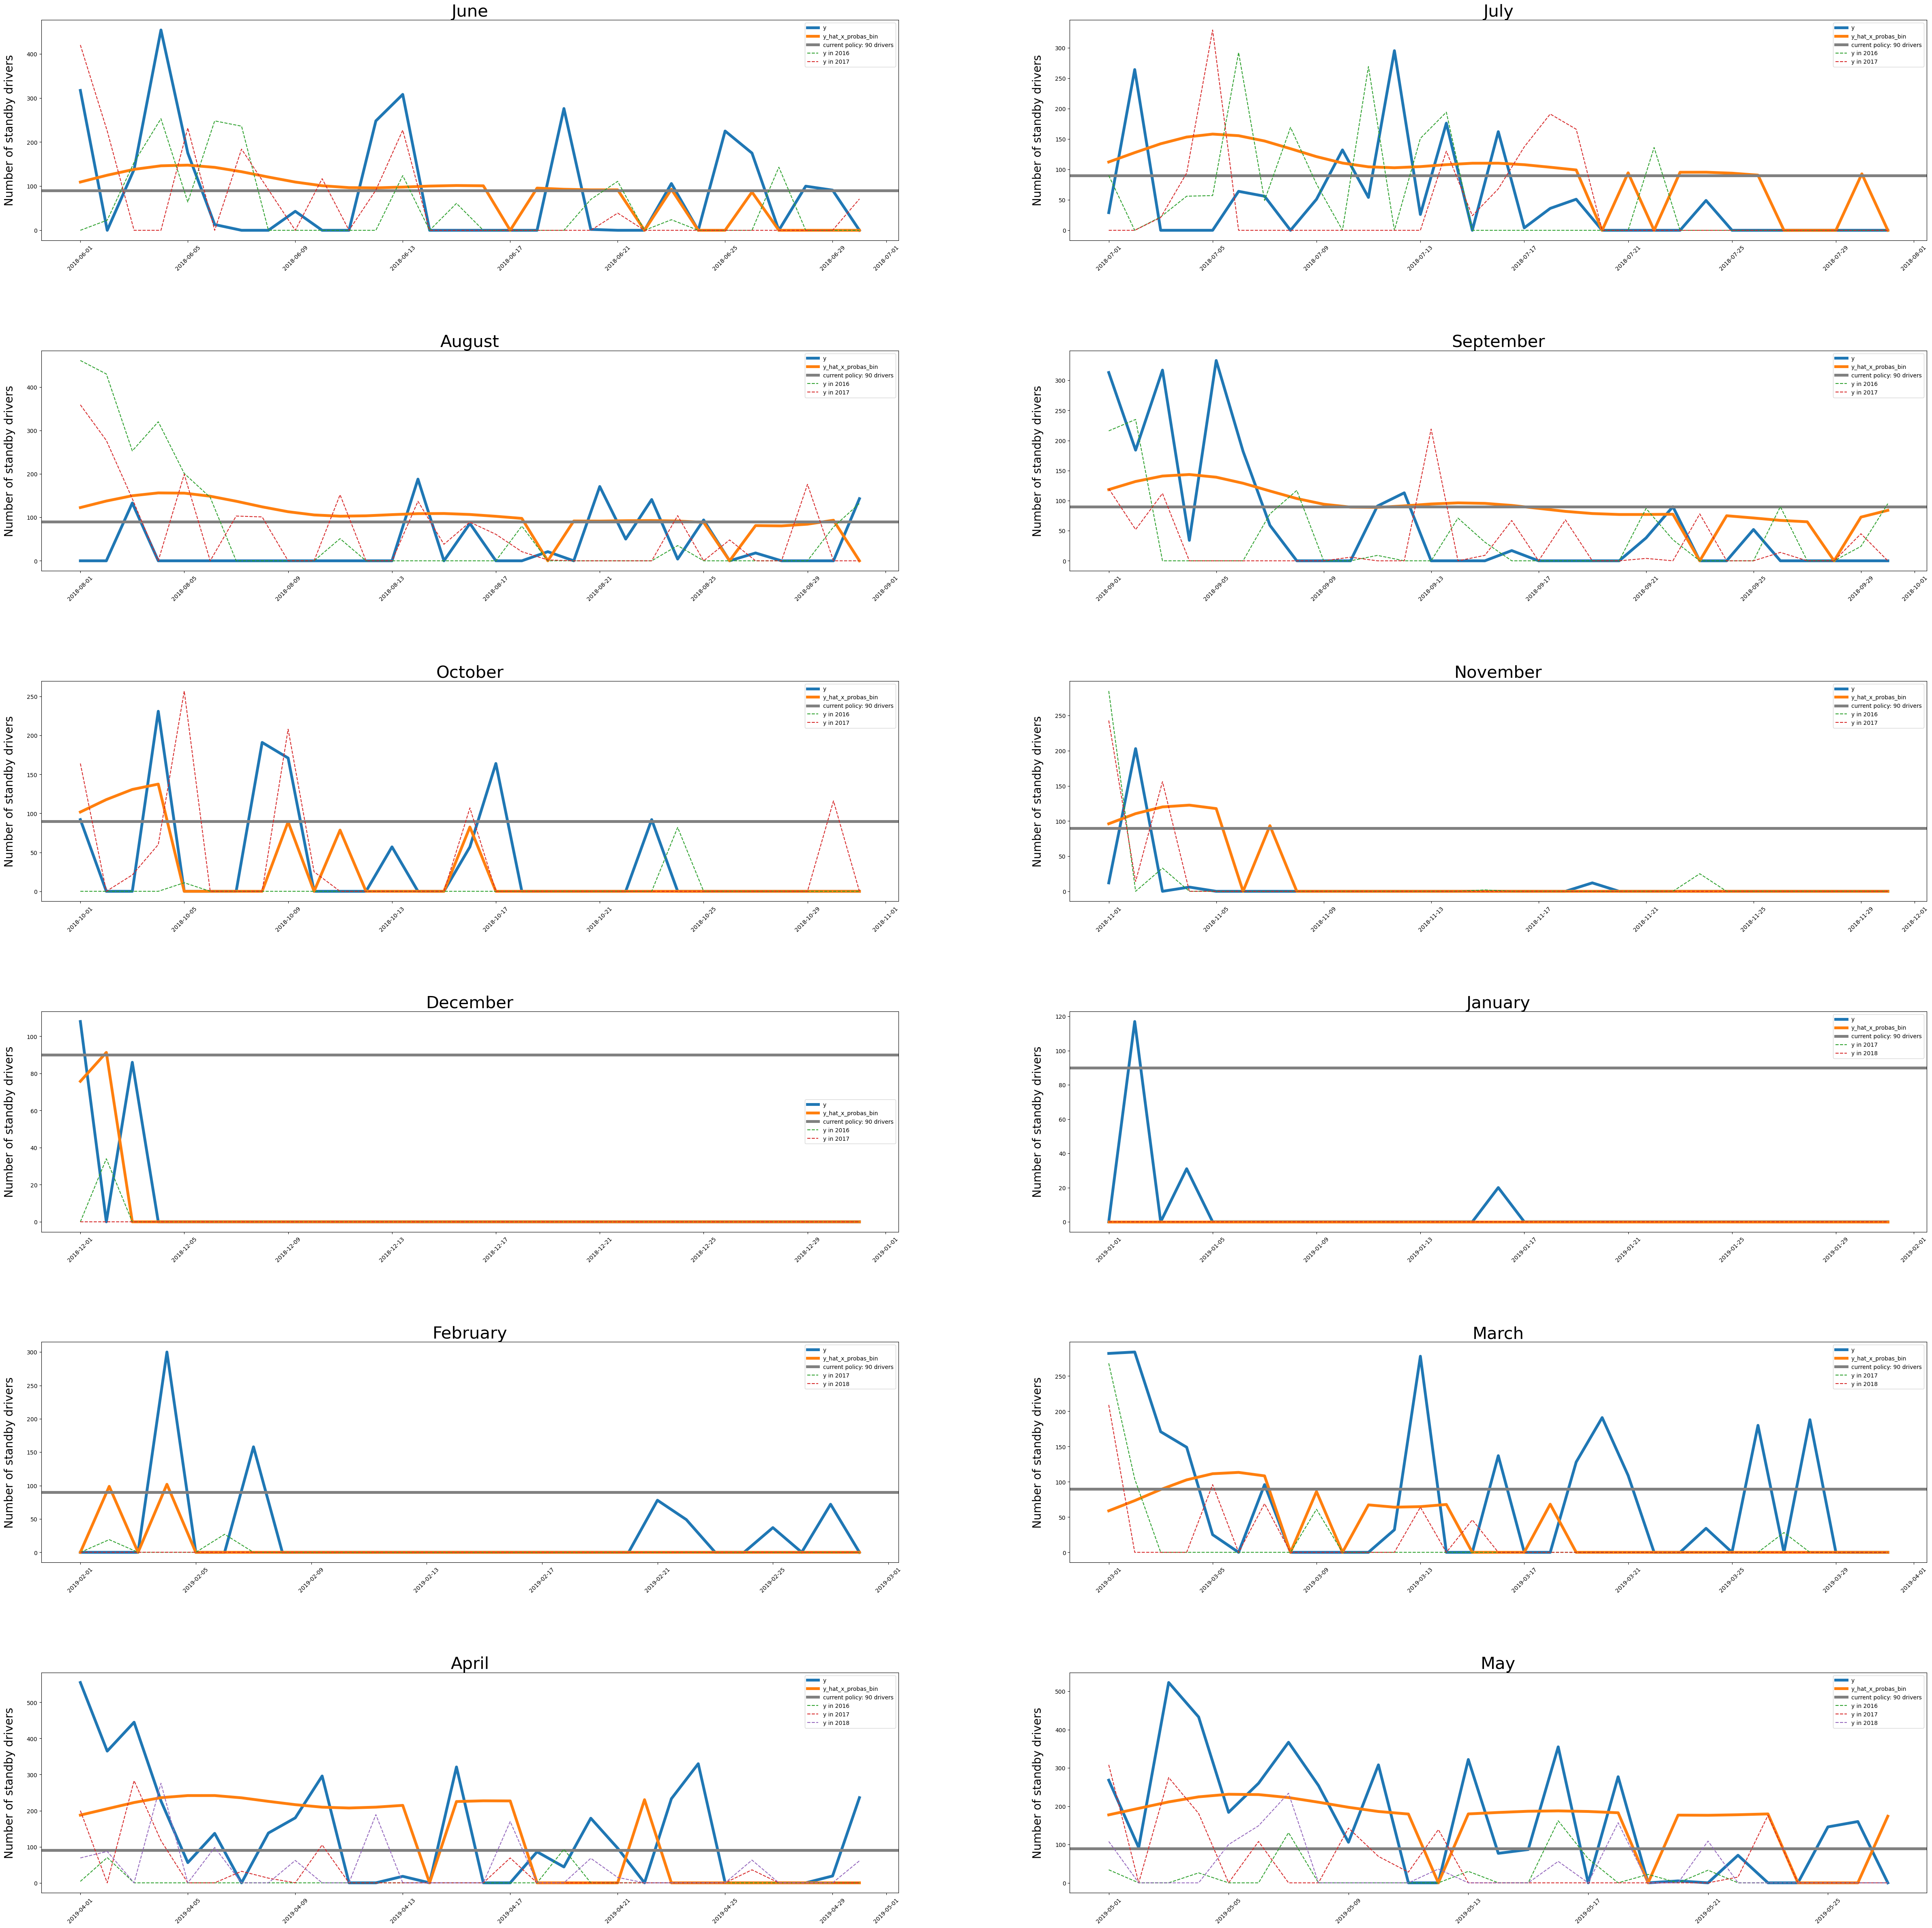

In [91]:
# decision threshold 0.2

combine_clf_reg(num_encoded_df, clf_probas, sarimax_bc_smooth_interval_bigger, year_split, interpretable_scores, plotting = True,
                     print_per_month = True, print_mean = True, smoothing = None, decision_thr = 0.2)

In summary, none of the tested SARIMAX models got close to the TBATS model in performance when combined with an upstream classifier.

As the SARIMAX model was the last approach that I had on my list of models with the highest potential for this use case, the search for other regressors was concluded here, and the TBATS model identified earlier was chosen as the regressor for the final model.

Possibly, the TBATS model could be improved further by adding bagging strategies.
However, due to time constraints, the decision was made to not implement this approach for the time being.

Next, model behavior will be analyzed in the notebook errors_and_interpret.